# Setup

In [39]:
from datetime import datetime, timedelta
from pathlib import Path
import re

import astropy.units as u
from astropy.coordinates import SkyCoord
from IPython.display import HTML, clear_output, display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reproject import reproject_interp
import requests
from scipy import ndimage as ndi
from skimage.draw import line as skline
from skimage.morphology import skeletonize, disk as morph_disk
import sunpy.map
from sunpy.coordinates import HeliographicCarrington, frames
from sunpy.map import all_coordinates_from_map
from sunpy.visualization import colormaps as cm

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from Library.CH import *
from Library.Config import *
from Library.IO import *
from Library.Model import *
from Library.Plot import *
from Library.Processing import *

from Models import load_date_range


In [42]:
# Notebook-level HMI defaults
DEFAULT_B_THRESH = 12
DEFAULT_HMI_SMOOTH_SIGMA = 1
DEFAULT_ANGLE_CORRECTION = True
DEFAULT_MASK_OVER_60 = True
DEFAULT_HMI_SMOOTH = True
DEFAULT_MU_CORRECT_WEAK_FIELD = True



# Data & Model

In [5]:
df = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

ARCH_ID = "A2"
DATE_ID = "D2"

date_range = load_date_range(ARCH_ID, DATE_ID)
train_df, val_df = date_range.select_pairs(df)

if val_df is None:
    inf_df = df.loc[~df.index.isin(train_df.index)]
else:
    combined_df = pd.concat([train_df, val_df])
    inf_df = df.loc[~df.index.isin(combined_df.index)]

model = load_trained_model(ARCH_ID, DATE_ID)
print(
    f"train: {len(train_df)}  val: {len(val_df) if val_df is not None else 0}  inf: {len(inf_df)}"
)

/Users/aosh/Developer/helio-n/Outputs/Models/A2D2.keras


I0000 00:00:1772026190.813188   94794 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1772026190.813370   94794 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


train: 5240  val: 580  inf: 14346


In [6]:
# Pick a sample row (with HMI data)
df_valid = df.dropna(subset=["hmi_path"])
row = df_valid.iloc[200]
print(row.name, row.fits_path)

20100702_1752 /Volumes/Aux Disk/mnt~sun/FITS/2010/07/02/AIA20100702_1752_0193.fits


# HMI

## Data

### `load_observation` — load AIA 193, AIA 304, HMI and reproject

In [7]:
def load_observation(row):
    """
    Load AIA 193 Å, (optional) AIA 304 Å, and HMI magnetogram.
    HMI is reprojected onto the AIA 193 pixel grid.

    Returns
    -------
    dict with keys:
        aia       : 2-D array (normalised AIA 193 image)
        aia_map   : sunpy Map of AIA 193
        hmi       : 2-D float32 array (reprojected HMI, NaN→0)
        aia304    : 2-D array or None
        has_304   : bool
    """
    _, aia = prepare_fits(row.fits_path)
    aia_map = sunpy.map.Map(row.fits_path)
    hmi_map = sunpy.map.Map(row.hmi_path)

    hmi_reprojected, _ = reproject_interp(hmi_map, aia_map.wcs, shape_out=aia.shape)
    hmi = np.flipud(hmi_reprojected.astype(np.float32))
    hmi = np.nan_to_num(hmi, nan=0.0)

    has_304 = hasattr(row, "aia304_path") and pd.notna(row.aia304_path)
    aia304 = None
    if has_304:
        try:
            _, aia304 = prepare_fits(row.aia304_path)
        except Exception:
            has_304 = False

    return {
        "aia": aia,
        "aia_map": aia_map,
        "hmi": hmi,
        "aia304": aia304,
        "has_304": has_304,
    }

### `compute_heliocentric_angles` — θ and cos θ maps from WCS

In [8]:
def compute_heliocentric_angles(aia_map):
    """
    Compute heliocentric angle θ (degrees) and cos(θ) for every pixel.

    Returns
    -------
    theta_deg : 2-D array (flipped to match imshow orientation)
    cos_theta : 2-D array
    """
    coords = all_coordinates_from_map(aia_map)
    hpc = coords.transform_to(
        frames.Helioprojective(observer=aia_map.observer_coordinate)
    )
    rho_deg = np.sqrt(hpc.Tx.to(u.deg).value ** 2 + hpc.Ty.to(u.deg).value ** 2)
    r_sun_deg = float(aia_map.rsun_obs.to(u.deg).value)
    sin_theta = np.clip(rho_deg / r_sun_deg, 0, 1)
    theta_rad = np.arcsin(sin_theta)
    theta_deg = np.flipud(np.degrees(theta_rad))
    cos_theta = np.flipud(np.cos(theta_rad))
    return theta_deg, cos_theta

### `apply_angle_correction` — unified cutoff + B_los → B_r

In [9]:
def smooth_hmi(hmi, sigma=DEFAULT_HMI_SMOOTH_SIGMA, mask=None):
    """Apply Gaussian smoothing to the HMI magnetogram.

    If mask is provided, perform normalized masked smoothing:
        G(hmi * mask) / G(mask)
    to avoid contamination from masked-out pixels.
    """
    hmi64 = hmi.astype(np.float64)
    if mask is None:
        return ndi.gaussian_filter(hmi64, sigma=sigma).astype(np.float32)

    mask_f = mask.astype(np.float64)
    weighted = ndi.gaussian_filter(hmi64 * mask_f, sigma=sigma)
    weights = ndi.gaussian_filter(mask_f, sigma=sigma)

    out = np.zeros_like(hmi64, dtype=np.float64)
    valid = weights > 0
    out[valid] = weighted[valid] / weights[valid]
    return out.astype(np.float32)


def apply_angle_correction(
    hmi, theta_deg, cos_theta, angle_correction=DEFAULT_ANGLE_CORRECTION, mask_over_60=DEFAULT_MASK_OVER_60
):
    """
    Apply unified angle cutoff and optional B_los → B_r correction.

    Cutoff logic:
      mask_over_60 ON  → 60° (cos ≥ 0.5)
      mask_over_60 OFF + angle_correction ON → 80° (implicit limb safety)
      both OFF → no cutoff

    Returns
    -------
    hmi_corrected : 2-D float32 (zeroed outside safe zone when correcting)
    angle_mask    : 2-D bool (True = inside safe zone)
    angle_cutoff  : float or None
    """
    if mask_over_60:
        angle_cutoff = 60.0
    elif angle_correction:
        angle_cutoff = 80.0
    else:
        angle_cutoff = None

    angle_mask = np.ones_like(hmi, dtype=bool)
    if angle_cutoff is not None:
        angle_mask = theta_deg <= angle_cutoff

    hmi_out = hmi.copy()
    if angle_correction:
        hmi_out = np.where(angle_mask, hmi_out / cos_theta, 0.0).astype(np.float32)

    return hmi_out, angle_mask, angle_cutoff


def process_hmi_ordered(
    hmi_raw,
    theta_deg,
    cos_theta,
    disk_mask,
    angle_correction=DEFAULT_ANGLE_CORRECTION,
    mask_over_60=DEFAULT_MASK_OVER_60,
    sigma=DEFAULT_HMI_SMOOTH_SIGMA,
    b_center_cutoff=DEFAULT_B_THRESH,
    mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
):
    """
    Ordered HMI processing pipeline:
      1) off-disk mask
      2) mu cutoff (60° when enabled, else legacy cutoff logic)
      3) Gaussian smoothing
      4) mu-scaled |B| cutoff (|B_los| >= b_center_cutoff * mu)
      5) mu correction (B_los -> B_r)

    Returns
    -------
    hmi_stage4      : float32, post-cutoff B_los-like field
    hmi_corrected   : float32, post-mu-correction field
    angle_mask      : bool
    angle_cutoff    : float or None
    mu_map          : float32
    """
    if mask_over_60:
        angle_cutoff = 60.0
    elif angle_correction:
        angle_cutoff = 80.0
    else:
        angle_cutoff = None

    angle_mask = np.ones_like(hmi_raw, dtype=bool)
    if angle_cutoff is not None:
        angle_mask = theta_deg <= angle_cutoff

    mu_map = np.clip(cos_theta.astype(np.float32), 0.0, 1.0)
    valid_mask = disk_mask & angle_mask

    # 1) off-disk mask + 2) mu cutoff
    hmi_stage2 = np.where(valid_mask, hmi_raw, 0.0).astype(np.float32)

    # 3) Gaussian smoothing inside valid region only
    hmi_stage3 = smooth_hmi(hmi_stage2, sigma=sigma, mask=valid_mask)
    hmi_stage3 = np.where(valid_mask, hmi_stage3, 0.0).astype(np.float32)

    # 4) mu-scaled |B| cutoff (center threshold scaled by mu)
    cutoff_map = (float(b_center_cutoff) * mu_map).astype(np.float32)
    hmi_stage4 = np.where(np.abs(hmi_stage3) >= cutoff_map, hmi_stage3, 0.0).astype(np.float32)
    hmi_stage4 = np.where(valid_mask, hmi_stage4, 0.0).astype(np.float32)

    # 5) mu correction
    hmi_for_correction = hmi_stage3 if mu_correct_weak_field else hmi_stage4
    if angle_correction:
        corr_mask = valid_mask & (mu_map > 0)
        hmi_corrected = np.where(corr_mask, hmi_for_correction / mu_map, 0.0).astype(np.float32)
    else:
        hmi_corrected = hmi_stage4.copy()

    return hmi_stage4, hmi_corrected, angle_mask, angle_cutoff, mu_map


### `compute_elongation` — region elongation from second moments

In [10]:
def compute_elongation(binary_mask):
    """
    Compute elongation of a binary region from its second central moments.

    Elongation = 1 - (minor_axis / major_axis).
    0 = perfectly circular, approaching 1 = very elongated.

    Uses eigenvalues of the 2×2 inertia tensor to find principal axes.

    Parameters
    ----------
    binary_mask : 2-D bool array

    Returns
    -------
    float  (0–1)
    """
    ys, xs = np.where(binary_mask)
    if len(ys) < 2:
        return 0.0

    cy, cx = ys.mean(), xs.mean()
    dy, dx = ys - cy, xs - cx

    # 2×2 covariance / inertia tensor
    Ixx = np.mean(dx * dx)
    Iyy = np.mean(dy * dy)
    Ixy = np.mean(dx * dy)

    # Eigenvalues → principal axes lengths (proportional to sqrt(eigenvalue))
    T = Ixx + Iyy
    D = Ixx * Iyy - Ixy * Ixy
    disc = max(T * T / 4 - D, 0.0)
    lam1 = T / 2 + np.sqrt(disc)
    lam2 = T / 2 - np.sqrt(disc)

    major = np.sqrt(max(lam1, 0.0))
    minor = np.sqrt(max(lam2, 0.0))

    if major == 0:
        return 0.0
    return float(1.0 - minor / major)

### `extract_hole_data` — per-component statistics

In [11]:
def extract_hole_data(labeled, n_holes, hmi_data):
    """
    For each labelled connected component, extract HMI values
    and summary statistics including elongation.

    Returns list of dicts, one per hole.
    """
    holes = []
    for hole_id in range(1, n_holes + 1):
        hole_mask = labeled == hole_id
        hmi_values = hmi_data[hole_mask]
        centroid = ndi.center_of_mass(hole_mask)
        elongation = compute_elongation(hole_mask)
        holes.append(
            {
                "label": hole_id,
                "hmi_values": hmi_values,
                "area_px": int(hole_mask.sum()),
                "centroid": centroid,
                "mean_hmi": float(hmi_values.mean()),
                "std_hmi": float(hmi_values.std()),
                "elongation": elongation,
            },
        )
    return holes


def build_merged_holes(nn_labeled, sdo_labeled, hmi_data):
    """
    Merge masked fragments by their unclipped SDO label.
    """
    merged_labeled = np.where(nn_labeled > 0, sdo_labeled, 0)
    labels = [int(label) for label in np.unique(merged_labeled) if label != 0]
    holes = []
    for label in labels:
        hole_mask = merged_labeled == label
        hmi_values = hmi_data[hole_mask]
        centroid = ndi.center_of_mass(hole_mask)
        elongation = compute_elongation(hole_mask)
        holes.append(
            {
                "label": label,
                "hmi_values": hmi_values,
                "area_px": int(hole_mask.sum()),
                "centroid": centroid,
                "mean_hmi": float(hmi_values.mean()) if hmi_values.size else np.nan,
                "std_hmi": float(hmi_values.std()) if hmi_values.size else np.nan,
                "elongation": elongation,
            },
        )
    return merged_labeled, holes


def extract_304_hole_stats_by_labels(aia304, labeled, labels):
    """
    Extract per-hole 304 A brightness stats for arbitrary label IDs.
    """
    if aia304 is None:
        return []
    holes = []
    for label in labels:
        hole_mask = labeled == label
        if not hole_mask.any():
            holes.append(
                {
                    "label": label,
                    "brightness_mean": np.nan,
                    "brightness_dark_skew": np.nan,
                    "n_pixels": 0,
                },
            )
            continue
        brightness_vals = aia304[hole_mask]
        mean_br = float(np.mean(brightness_vals))
        inverted = 1.0 - brightness_vals
        if len(inverted) > 2:
            std_inv = float(np.std(inverted))
            if std_inv > 0:
                centered = inverted - np.mean(inverted)
                dark_skew = float(np.mean(centered**3) / (std_inv**3))
            else:
                dark_skew = np.nan
        else:
            dark_skew = np.nan
        holes.append(
            {
                "label": label,
                "brightness_mean": mean_br,
                "brightness_dark_skew": dark_skew,
                "n_pixels": int(hole_mask.sum()),
            },
        )
    return holes

### `label_coronal_holes` — mask, label, extract per-hole data

In [12]:
def label_coronal_holes(row, model, hmi, angle_mask, smoothing_params=None):
    """
    Obtain U-Net and IDL binary masks, apply angle mask, then label
    connected components and extract per-hole HMI statistics.

    Returns
    -------
    dict with keys:
        nn_labeled, nn_n_holes, nn_holes,
        idl_labeled, idl_n_holes, idl_holes
    """
    if smoothing_params is None:
        smoothing_params = get_postprocessing_params("P1")

    pmap = find_or_make_pmap(row, model)
    nn_mask = (pmap_to_mask(pmap, smoothing_params) > 0.5) & angle_mask

    idl_mask = (prepare_mask(row.mask_path) > 0.5) & angle_mask

    nn_labeled, nn_n_holes = ndi.label(nn_mask)
    idl_labeled, idl_n_holes = ndi.label(idl_mask)

    nn_holes = extract_hole_data(nn_labeled, nn_n_holes, hmi)
    idl_holes = extract_hole_data(idl_labeled, idl_n_holes, hmi)

    return {
        "nn_labeled": nn_labeled,
        "nn_n_holes": nn_n_holes,
        "nn_holes": nn_holes,
        "idl_labeled": idl_labeled,
        "idl_n_holes": idl_n_holes,
        "idl_holes": idl_holes,
    }

### `compute_stats` — mean, skewness, flux ratio

In [13]:
def compute_stats(values):
    """
    Compute summary statistics for a 1-D array of HMI values.

    Returns dict with keys: mean, skew, flux_ratio, pos_sum, neg_sum.
    """
    values = np.asarray(values)
    if values.size == 0:
        return {
            "mean": np.nan,
            "skew": np.nan,
            "flux_ratio": np.nan,
            "pos_sum": np.nan,
            "neg_sum": np.nan,
        }

    mean_val = float(values.mean())
    std_val = float(values.std())
    if std_val == 0.0 or values.size < 3:
        skew_val = np.nan
    else:
        centered = values - mean_val
        skew_val = float(np.mean(centered**3) / (std_val**3))

    abs_sum = float(np.sum(np.abs(values)))
    flux_ratio = float(np.abs(np.sum(values)) / abs_sum) if abs_sum != 0.0 else np.nan
    pos_sum = float(np.sum(values[values > 0]))
    neg_sum = float(np.sum(values[values < 0]))
    return {
        "mean": mean_val,
        "skew": skew_val,
        "flux_ratio": flux_ratio,
        "pos_sum": pos_sum,
        "neg_sum": neg_sum,
    }

In [14]:
def _overlay_contours(ax, labeled, holes, show_labels=False):
    """Draw CH contours on the given axes, colored by mean HMI polarity."""
    for hole in holes:
        mask = (labeled == hole["label"]).astype(float)
        color = "red" if hole["mean_hmi"] >= 0 else "blue"
        ax.contour(mask, levels=[0.5], colors=color, linewidths=2)
        if show_labels:
            cy, cx = hole["centroid"]
            ax.text(
                cx,
                cy,
                str(hole["label"]),
                fontsize=12,
                color="white",
                ha="center",
                va="center",
                weight="bold",
                bbox=dict(boxstyle="circle", facecolor="orange", alpha=0.7),
            )


def _overlay_filaments(ax, aia_map, filaments_df, color="lime", lw=1.5, alpha=0.9):
    """Draw Kislovodsk filament segments on the given axes.

    world_to_pixel returns FITS-convention y (row 0 = south).
    The displayed data has been np.flipud'd (row 0 = north) and is
    shown with origin='upper', so we convert:  y_disp = (Ny-1) - y_fits.
    """
    if filaments_df is None or aia_map is None or len(filaments_df) == 0:
        return 0

    Ny = aia_map.data.shape[0]

    try:
        observer = aia_map.observer_coordinate
    except Exception:
        observer = "earth"
    obstime = aia_map.date

    n_plotted = 0
    for _, fil in filaments_df.iterrows():
        try:
            frame = HeliographicCarrington(observer=observer, obstime=obstime)
            c1 = SkyCoord(lon=fil.lon1 * u.deg, lat=fil.lat1 * u.deg, frame=frame)
            c2 = SkyCoord(lon=fil.lon2 * u.deg, lat=fil.lat2 * u.deg, frame=frame)
            px1 = aia_map.world_to_pixel(c1)
            px2 = aia_map.world_to_pixel(c2)
            y1 = (Ny - 1) - px1.y.value
            y2 = (Ny - 1) - px2.y.value
            ax.plot(
                [px1.x.value, px2.x.value],
                [y1, y2],
                color=color,
                lw=lw,
                alpha=alpha,
            )
            n_plotted += 1
        except Exception:
            continue

    return n_plotted

### `plot_multiband` — 2- or 3-panel image display

In [15]:
def plot_multiband(
    aia,
    hmi,
    nn_labeled,
    nn_holes,
    aia304=None,
    has_304=False,
    corr_label="B_los",
    mask_label="",
    aia_map=None,
    filaments_df=None,
    hmi_full=None,
    crop_mask=None,
    sdo_labeled=None,
    sdo_holes=None,
):
    """
    Show AIA 193, (optional) AIA 304, and HMI side-by-side
    with polarity contours overlaid.

    Parameters
    ----------
    aia : 2-D array — AIA 193 Å image (full, untruncated)
    hmi : 2-D array — HMI for calculations (angle-corrected, possibly masked)
    nn_labeled : 2-D int array — labeled coronal holes for HMI/stat views
    nn_holes : list of dicts — per-hole metadata for HMI/stat views
    aia304 : 2-D array, optional — AIA 304 Å image
    has_304 : bool — whether AIA 304 is available
    corr_label : str — label for HMI correction method
    mask_label : str — additional label for mask info
    aia_map : sunpy.map.Map, optional — for filament overlays
    filaments_df : pd.DataFrame, optional — filament catalog
    hmi_full : 2-D array, optional — full HMI for display (if None, uses hmi)
    crop_mask : 2-D bool array, optional — mask boundary to overlay (e.g., angle mask)
    sdo_labeled : 2-D int array, optional — CH labels for AIA/SDO overlays
    sdo_holes : list of dicts, optional — CH metadata for AIA/SDO overlays
    """
    hmi_norm = np.clip(hmi, -1000, 1000)
    hmi_norm = (hmi_norm + 1000) / 2000

    # If full HMI provided, normalize that for display instead
    if hmi_full is not None:
        hmi_display = np.clip(hmi_full, -1000, 1000)
        hmi_display = (hmi_display + 1000) / 2000
    else:
        hmi_display = hmi_norm

    if sdo_labeled is None:
        sdo_labeled = nn_labeled
    if sdo_holes is None:
        sdo_holes = nn_holes

    n_images = 3 if has_304 else 2
    fig = plt.figure(figsize=(5 * n_images, 5))

    # --- AIA 193 ---
    ax = fig.add_subplot(1, n_images, 1)
    ax.imshow(aia, cmap=cm.cmlist.get("sdoaia193"))
    _overlay_contours(ax, sdo_labeled, sdo_holes, show_labels=True)
    if filaments_df is not None and aia_map is not None:
        _overlay_filaments(ax, aia_map, filaments_df, color="lime")
    ax.set_title(f"AIA 193 Å | {len(sdo_holes)} holes (U-Net)")
    ax.axis("off")

    # --- AIA 304 ---
    if has_304 and aia304 is not None:
        ax = fig.add_subplot(1, n_images, 2)
        ax.imshow(aia304, cmap=cm.cmlist.get("sdoaia304"))
        _overlay_contours(ax, sdo_labeled, sdo_holes)
        if filaments_df is not None and aia_map is not None:
            _overlay_filaments(ax, aia_map, filaments_df, color="lime")
        ax.set_title("AIA 304 Å")
        ax.axis("off")

    # --- HMI ---
    ax = fig.add_subplot(1, n_images, n_images)
    hmi_plot = hmi_display
    hmi_cmap = cm.cmlist["hmimag"]

    # Mask off-disk to black for display (zero otherwise maps to hmimag mid-color)
    if aia_map is not None:
        hpc_coords = all_coordinates_from_map(aia_map)
        disk_mask = coordinate_is_on_solar_disk(hpc_coords)
        disk_mask = np.flipud(disk_mask)
        hmi_plot = np.ma.array(hmi_display, mask=~disk_mask)
        hmi_cmap = cm.cmlist["hmimag"].copy()
        hmi_cmap.set_bad("black")

    ax.imshow(hmi_plot, cmap=hmi_cmap)
    _overlay_contours(ax, nn_labeled, nn_holes)

    # Overlay theta-cutoff boundary on HMI only (high-visibility dashed black)
    if crop_mask is not None:
        boundary = ndi.binary_dilation(crop_mask) ^ crop_mask
        # White halo underlay for contrast against both dark and bright background
        ax.contour(
            boundary.astype(float),
            levels=[0.5],
            colors="white",
            linewidths=4.0,
            linestyles="dashed",
            alpha=0.95,
        )
        # Main dashed black cutoff line
        ax.contour(
            boundary.astype(float),
            levels=[0.5],
            colors="black",
            linewidths=2.4,
            linestyles="dashed",
            alpha=1.0,
        )

    if filaments_df is not None and aia_map is not None:
        _overlay_filaments(ax, aia_map, filaments_df, color="lime")
    ax.set_title(f"HMI ({corr_label}){mask_label}")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


## Distributions

### `plot_hole_histograms` — per-hole B-field distributions

In [16]:
def plot_hole_histograms(holes, B_thresh=DEFAULT_B_THRESH):
    """
    Plot a grid of histograms, one per coronal hole.
    Values below ±B_thresh are excluded.
    """
    n = len(holes)
    if n == 0:
        print("No holes to plot.")
        return

    n_cols = 2
    n_rows = max(1, (n + n_cols - 1) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for idx, hole in enumerate(holes):
        ax = axes[idx]
        vals_raw = hole["hmi_values"]
        if len(vals_raw) == 0:
            ax.text(
                0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes
            )
            ax.set_title(f"Hole #{hole['label']}")
            continue

        vals = vals_raw[np.abs(vals_raw) >= B_thresh]
        if len(vals) == 0:
            ax.text(
                0.5,
                0.5,
                "No data after threshold",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_title(f"Hole #{hole['label']}")
            continue

        stats = compute_stats(vals)
        mean_val = stats["mean"]
        skew_val = stats["skew"]
        color = "red" if mean_val >= 0 else "blue"

        lo = np.floor(vals.min() / 2) * 2 - 1
        hi = np.ceil(vals.max() / 2) * 2 + 1
        bins = np.arange(lo, hi + 2, 2)

        ax.hist(vals, bins=bins, color=color, alpha=0.7, edgecolor="black")
        ax.set_xlim(-50, 50)
        ax.set_xlabel("HMI [Gauss]")
        ax.set_ylabel("Count")
        ax.set_yscale("log")
        ax.set_title(f"Hole #{hole['label']}: n={len(vals)}px, skew={skew_val:.2f}")
        ax.grid(alpha=0.3)

    for idx in range(n, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

### `build_stats_table` — styled HTML statistics summary

In [17]:
def build_stats_table_data(
    nn_holes,
    B_thresh=DEFAULT_B_THRESH,
    filament_overlaps=None,
    sigma_filament=10.0,
    hole_304_stats=None,
):
    """
    Build a DataFrame of per-hole statistics.

    Columns: geometry (area, elongation), HMI polarity (raw & thresholded),
    304 Å brightness, filament overlap S_C.
    """
    sc_map = {}
    if filament_overlaps is not None:
        sc_map = {o["label"]: o["S_C"] for o in filament_overlaps}

    br_map = {}
    if hole_304_stats is not None:
        br_map = {h["label"]: h for h in hole_304_stats}

    sc_col = f"S_C(σ{sigma_filament:.0f})"

    rows = []
    for hole in nn_holes:
        raw = hole["hmi_values"]
        thr = raw[np.abs(raw) >= B_thresh]
        sr = compute_stats(raw)
        st = compute_stats(thr)

        elong = hole.get("elongation", np.nan)
        sc_val = sc_map.get(hole["label"], np.nan)

        br = br_map.get(hole["label"], {})
        br_mean = br.get("brightness_mean", np.nan)
        br_skew = br.get("brightness_dark_skew", np.nan)

        rows.append(
            {
                "CH": hole["label"],
                "Area [px]": hole["area_px"],
                "Elong": elong,
                sc_col: sc_val,
                "B_mean [G]": sr["mean"],
                "B_mean_thr": st["mean"],
                "HMI skew": sr["skew"],
                "HMI skew_thr": st["skew"],
                "|Σ|/Σ||": sr["flux_ratio"],
                "|Σ|/Σ||_thr": st["flux_ratio"],
                "Sum+ [G]": sr["pos_sum"],
                "Sum- [G]": sr["neg_sum"],
                "Sum+_thr": st["pos_sum"],
                "Sum-_thr": st["neg_sum"],
                "304 mean": br_mean,
                "304 dark skew": br_skew,
            }
        )

    return pd.DataFrame(rows).set_index("CH")


def build_stats_table(
    nn_holes=None,
    B_thresh=DEFAULT_B_THRESH,
    corr_label="B_los",
    mask_label="",
    filament_overlaps=None,
    sigma_filament=10.0,
    hole_304_stats=None,
    hmi_smooth=False,
    stats_table=None,
):
    """
    Build a styled HTML table of per-hole statistics and return the Styler.

    Columns: geometry (area, elongation), HMI polarity (raw & thresholded),
    304 Å brightness, filament overlap S_C.

    Returns
    -------
    pandas.io.formats.style.Styler
    """
    sc_col = f"S_C(σ{sigma_filament:.0f})"

    if stats_table is None:
        tbl = build_stats_table_data(
            nn_holes,
            B_thresh=B_thresh,
            filament_overlaps=filament_overlaps,
            sigma_filament=sigma_filament,
            hole_304_stats=hole_304_stats,
        )
    else:
        tbl = stats_table

    smooth_tag = f", σ_HMI={DEFAULT_HMI_SMOOTH_SIGMA:.1f} px" if hmi_smooth else ""
    caption = (
        f"U-Net CH stats &nbsp;[{corr_label}{mask_label}{smooth_tag}]"
        f" &nbsp; B_thr={B_thresh} G"
    )

    fmt = {
        "Area [px]": "{:,}",
        "Elong": "{:.2f}",
        sc_col: "{:.4f}",
        "B_mean [G]": "{:.1f}",
        "B_mean_thr": "{:.1f}",
        "HMI skew": "{:.2f}",
        "HMI skew_thr": "{:.2f}",
        "|Σ|/Σ||": "{:.3f}",
        "|Σ|/Σ||_thr": "{:.3f}",
        "Sum+ [G]": "{:.2e}",
        "Sum- [G]": "{:.2e}",
        "Sum+_thr": "{:.2e}",
        "Sum-_thr": "{:.2e}",
        "304 mean": "{:.3f}",
        "304 dark skew": "{:.2f}",
    }

    def _colour_polarity(val):
        if pd.isna(val):
            return ""
        return "color: #d32f2f" if val >= 0 else "color: #1565c0"

    styler = (
        tbl.style.format(fmt, na_rep="–")
        .set_caption(caption)
        .applymap(_colour_polarity, subset=["B_mean [G]", "B_mean_thr"])
        .set_table_styles(
            [
                {
                    "selector": "caption",
                    "props": "font-weight:bold; font-size:13px; text-align:left; padding-bottom:6px;",
                },
                {
                    "selector": "th",
                    "props": "font-size:11px; white-space:nowrap; padding:3px 6px;",
                },
                {
                    "selector": "td",
                    "props": "font-size:11px; white-space:nowrap; padding:3px 6px;",
                },
            ]
        )
    )
    return styler

## PILs

In [18]:
def compute_pils(
    hmi_raw,
    gauss_sigma=3.0,
    cutoff_gauss=20.0,
    dilation_px=5,
    min_length=30,
    min_polarity_area=0,
    do_skeleton=True,
    mu_mask=None,
):
    """
    Compute Polarity Inversion Lines from an HMI magnetogram.

    Steps
    -----
    1. Gaussian-smooth the HMI data (sigma = gauss_sigma).
    2. Apply mu mask to polarity thresholding only (theta <= 60 deg).
    3. Threshold at ±cutoff_gauss to build positive / negative polarity masks.
    4. Dilate both masks with a disk structuring element of radius dilation_px.
    5. Remove small polarity components after dilation (min_polarity_area).
    6. PIL region = overlap of dilated positive & dilated negative.
    7. Skeletonize to 1-pixel width (optional).
    8. Label connected components and remove those shorter than min_length px.

    Returns
    -------
    hmi_smooth, pos_mask, neg_mask, pil_region, pil_lines
    """
    hmi_smooth = ndi.gaussian_filter(
        hmi_raw.astype(np.float64), sigma=gauss_sigma
    ).astype(np.float32)
    if mu_mask is not None:
        hmi_for_pol = np.where(mu_mask, hmi_smooth, 0.0).astype(np.float32)
    else:
        hmi_for_pol = hmi_smooth

    pos_mask = hmi_for_pol > cutoff_gauss
    neg_mask = hmi_for_pol < -cutoff_gauss

    struct = morph_disk(dilation_px)
    pos_dilated = ndi.binary_dilation(pos_mask, structure=struct)
    neg_dilated = ndi.binary_dilation(neg_mask, structure=struct)

    if min_polarity_area > 1:
        labeled_pos, n_pos = ndi.label(pos_dilated)
        for i in range(1, n_pos + 1):
            if np.sum(labeled_pos == i) < min_polarity_area:
                pos_dilated[labeled_pos == i] = False
        labeled_neg, n_neg = ndi.label(neg_dilated)
        for i in range(1, n_neg + 1):
            if np.sum(labeled_neg == i) < min_polarity_area:
                neg_dilated[labeled_neg == i] = False

    pil_region = pos_dilated & neg_dilated

    if do_skeleton:
        pil_lines = skeletonize(pil_region)
    else:
        pil_lines = pil_region.copy()

    labeled, n_comps = ndi.label(pil_lines)
    for i in range(1, n_comps + 1):
        if np.sum(labeled == i) < min_length:
            pil_lines[labeled == i] = False

    return hmi_smooth, pos_mask, neg_mask, pil_region, pil_lines


def compute_pil_context(row, model):
    """Load observation and compute angle-corrected HMI + CH mask for PIL overlays."""
    obs = load_observation(row)
    theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])
    hmi_corr, angle_mask, _ = apply_angle_correction(
        obs["hmi"],
        theta_deg,
        cos_theta,
        angle_correction=DEFAULT_ANGLE_CORRECTION,
        mask_over_60=DEFAULT_MASK_OVER_60,
    )
    mu_mask = theta_deg <= 60.0
    ch = label_coronal_holes(row, model, hmi_corr, angle_mask)
    ch_mask = ch["nn_labeled"] > 0
    return obs, ch_mask, hmi_corr, mu_mask


def plot_pils(
    hmi_raw,
    ch_mask,
    mu_mask,
    gauss_sigma,
    cutoff_gauss,
    dilation_px,
    min_length,
    min_polarity_area,
    do_skeleton,
):
    """Run PIL computation and display results on HMI + CH mask background."""
    hmi_smooth, pos_mask, neg_mask, pil_region, pil_lines = compute_pils(
        hmi_raw,
        gauss_sigma=gauss_sigma,
        cutoff_gauss=cutoff_gauss,
        dilation_px=dilation_px,
        min_length=min_length,
        min_polarity_area=min_polarity_area,
        do_skeleton=do_skeleton,
        mu_mask=mu_mask,
    )

    pos_px = int(pos_mask.sum())
    neg_px = int(neg_mask.sum())
    pil_region_px = int(pil_region.sum())

    n_pil_px = int(pil_lines.sum())
    labeled_pils, n_pils = ndi.label(pil_lines)

    print(
        f"pos={pos_px:,}  neg={neg_px:,}  overlap={pil_region_px:,}  "
        f"lines={n_pils} comps, {n_pil_px:,} px"
    )

    fig, axes = plt.subplots(1, 4, figsize=(22, 5.5))

    # 1 — Smoothed HMI with polarity masks
    ax = axes[0]
    hmi_disp = np.clip(hmi_smooth, -500, 500)
    ax.imshow(
        hmi_disp,
        cmap=cm.cmlist["hmimag"],
        vmin=-500,
        vmax=500,
        interpolation="nearest",
        resample=False,
    )
    ax.contour(pos_mask.astype(float), levels=[0.5], colors="red", linewidths=0.6)
    ax.contour(neg_mask.astype(float), levels=[0.5], colors="blue", linewidths=0.6)
    ax.set_title(f"HMI smooth σ={gauss_sigma:.1f} | cutoff ±{cutoff_gauss:.0f} G")
    ax.set_aspect("equal")
    ax.axis("off")

    # 2 — Dilated overlap (PIL region)
    ax = axes[1]
    ax.imshow(pil_region, cmap="gray_r", interpolation="nearest", resample=False)
    ax.set_title(f"PIL region (dilation r={dilation_px} px)")
    ax.set_aspect("equal")
    ax.axis("off")

    # 3 — Lines on HMI
    ax = axes[2]
    ax.imshow(
        hmi_disp,
        cmap=cm.cmlist["hmimag"],
        vmin=-500,
        vmax=500,
        interpolation="nearest",
        resample=False,
    )
    line_rgba = np.zeros((*pil_lines.shape, 4), dtype=np.float32)
    line_rgba[pil_lines, :] = [0.0, 1.0, 1.0, 1.0]
    ax.imshow(line_rgba, interpolation="nearest", resample=False)
    line_label = "skeleton" if do_skeleton else "region"
    ax.set_title(
        f"PILs {line_label} | {n_pils} comps, {n_pil_px} px (min {min_length})"
    )
    ax.set_aspect("equal")
    ax.axis("off")

    # 4 — Lines on CH mask
    ax = axes[3]
    ax.imshow(
        ch_mask.astype(float),
        cmap="gray",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        resample=False,
    )
    ax.imshow(line_rgba, interpolation="nearest", resample=False)
    ax.set_title("PILs on CH mask")
    ax.set_aspect("equal")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


# ── Interactive widget ─────────────────────────────────────────────
pil_full_row = widgets.Layout(width="100%")

pil_gauss_slider = widgets.FloatSlider(
    value=3.0,
    min=0.5,
    max=15.0,
    step=0.5,
    description="Gauss σ:",
    continuous_update=False,
    layout=pil_full_row,
)
pil_cutoff_slider = widgets.FloatSlider(
    value=20.0,
    min=1.0,
    max=100.0,
    step=1.0,
    description="Cutoff [G]:",
    continuous_update=False,
    layout=pil_full_row,
)
pil_dilation_slider = widgets.IntSlider(
    value=20,
    min=1,
    max=75,
    step=1,
    description="Dilation r:",
    continuous_update=False,
    layout=pil_full_row,
)
pil_minlen_slider = widgets.IntSlider(
    value=30,
    min=1,
    max=200,
    step=1,
    description="Min length:",
    continuous_update=False,
    layout=pil_full_row,
)
pil_minpol_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=1000,
    step=5,
    description="Min pol area:",
    continuous_update=False,
    layout=pil_full_row,
)
pil_skeleton_checkbox = widgets.Checkbox(
    value=True,
    description="Skeletonize",
    layout=widgets.Layout(margin="0 0 0 4px"),
)

pil_out = widgets.Output()

if "pil_cache" not in globals():
    pil_cache = {}

pil_row = df_valid.iloc[6666]


def update_pil_plot(change=None):
    with pil_out:
        clear_output(wait=True)
        cache_key = str(pil_row.name)
        cached = pil_cache.get(cache_key)
        if cached is not None and len(cached) == 4:
            obs_local, ch_mask, hmi_corr, mu_mask = cached
        else:
            obs_local, ch_mask, hmi_corr, mu_mask = compute_pil_context(pil_row, model)
            pil_cache[cache_key] = (obs_local, ch_mask, hmi_corr, mu_mask)

        plot_pils(
            hmi_corr,
            ch_mask,
            mu_mask,
            gauss_sigma=pil_gauss_slider.value,
            cutoff_gauss=pil_cutoff_slider.value,
            dilation_px=pil_dilation_slider.value,
            min_length=pil_minlen_slider.value,
            min_polarity_area=pil_minpol_slider.value,
            do_skeleton=pil_skeleton_checkbox.value,
        )


for _w in [
    pil_gauss_slider,
    pil_cutoff_slider,
    pil_dilation_slider,
    pil_minlen_slider,
    pil_minpol_slider,
    pil_skeleton_checkbox,
]:
    _w.observe(update_pil_plot, names="value")

pil_controls = widgets.VBox(
    [
        pil_gauss_slider,
        pil_cutoff_slider,
        pil_dilation_slider,
        pil_minlen_slider,
        pil_minpol_slider,
        pil_skeleton_checkbox,
        pil_out,
    ],
    layout=pil_full_row,
)

display(pil_controls)
update_pil_plot()

# 304A

## AIA 304 — brightness analysis (subfunctions)
Utility functions for computing disk mean and per-hole 304 Å statistics.

In [19]:
def compute_304_disk_brightness(aia304):
    """Compute mean 304 Å brightness across the full disk (no angle mask).
    Returns NaN if aia304 is None or contains no finite pixels.
    """
    if aia304 is None:
        return np.nan
    vals = np.asarray(aia304)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan
    return float(np.mean(vals))

In [20]:
def extract_304_hole_stats(aia304, labeled, n_holes):
    """Extract per-hole 304 Å brightness stats (mean + dark-skew).
    Returns list of dicts with keys: label, brightness_mean, brightness_dark_skew, n_pixels
    """
    if aia304 is None:
        return []
    holes = []
    for hole_id in range(1, n_holes + 1):
        hole_mask = labeled == hole_id
        if not hole_mask.any():
            holes.append(
                {
                    "label": hole_id,
                    "brightness_mean": np.nan,
                    "brightness_dark_skew": np.nan,
                    "n_pixels": 0,
                }
            )
            continue
        brightness_vals = aia304[hole_mask]
        mean_br = float(np.mean(brightness_vals))
        inverted = 1.0 - brightness_vals
        if len(inverted) > 2:
            std_inv = float(np.std(inverted))
            if std_inv > 0:
                centered = inverted - np.mean(inverted)
                dark_skew = float(np.mean(centered**3) / (std_inv**3))
            else:
                dark_skew = np.nan
        else:
            dark_skew = np.nan
        holes.append(
            {
                "label": hole_id,
                "brightness_mean": mean_br,
                "brightness_dark_skew": dark_skew,
                "n_pixels": int(hole_mask.sum()),
            }
        )
    return holes

In [21]:
def plot_304_brightness_analysis(aia304, labeled, n_holes, disk_brightness=None):
    """
    Plot 304 Å brightness analysis: disk mean, per-hole histograms, bar chart.
    """
    if aia304 is None:
        print("AIA 304 not available.")
        return

    if disk_brightness is None:
        disk_brightness = compute_304_disk_brightness(aia304)
    hole_stats = extract_304_hole_stats(aia304, labeled, n_holes)
    if not hole_stats:
        print("No holes found.")
        return

    n_holes_valid = len(hole_stats)
    fig = plt.figure(figsize=(14, 4 * max(1, (n_holes_valid + 1) // 2)))
    n_cols = 2
    n_rows = max(1, (n_holes_valid + n_cols - 1) // n_cols)

    for idx, h in enumerate(hole_stats):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        hole_mask = labeled == h["label"]
        brightness_vals = aia304[hole_mask]
        if len(brightness_vals) > 0:
            ax.hist(
                brightness_vals, bins=30, color="orange", alpha=0.7, edgecolor="black"
            )
            ax.axvline(
                h["brightness_mean"],
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {h['brightness_mean']:.3f}",
            )
            ax.axvline(
                disk_brightness,
                color="black",
                linestyle="--",
                linewidth=2,
                label=f"Disk: {disk_brightness:.3f}",
            )
            ax.set_xlabel("304 Å Brightness")
            ax.set_ylabel("Count")
            skew_label = (
                f"{h['brightness_dark_skew']:.2f}"
                if not np.isnan(h["brightness_dark_skew"])
                else "N/A"
            )
            ax.set_title(f"Hole #{h['label']}: Dark Skew = {skew_label}")
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)

    if n_holes_valid % 2 == 1:
        ax = plt.subplot(n_rows, n_cols, n_holes_valid + 1)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    hole_ids = [h["label"] for h in hole_stats]
    brightness_means = [h["brightness_mean"] for h in hole_stats]
    colors_bright = ["red" if b > disk_brightness else "blue" for b in brightness_means]
    ax.bar(
        hole_ids, brightness_means, color=colors_bright, alpha=0.7, edgecolor="black"
    )
    ax.axhline(
        disk_brightness,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Disk avg: {disk_brightness:.3f}",
    )
    ax.set_xlabel("Hole ID")
    ax.set_ylabel("Mean 304 Å Brightness")
    ax.set_title("Per-Hole 304 Å Brightness (red=brighter, blue=darker than disk)")
    ax.legend()
    ax.grid(alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

## Kislovodsk Filaments


### `load_kislovodsk_filaments`
Download and parse filament segments from the [Kislovodsk Mountain Station catalog](http://93.180.26.198:8000/web/fillaments/) for a given observation date.

In [22]:
def parse_kislovodsk_catalog(text):
    """Parse Kislovodsk catalog text into a DataFrame."""

    def _parse_float(val):
        s = str(val).strip().replace(",", ".")
        if s.lower() in {"nan", "na", "n/a"}:
            return float("nan")
        while s and s[0] not in "-0123456789.":
            s = s[1:]
        while s and s[-1] not in "0123456789":
            s = s[:-1]
        if s in {"", ".", "-", "-.", None}:
            raise ValueError("empty numeric")
        return float(s)

    rows = []
    for line_num, line in enumerate(text.splitlines(), start=1):
        parts = line.split()
        if len(parts) not in (7, 8):
            continue
        try:
            # Detect format: YYYYMM DD ... (2012+) vs YYYY MM DD ... (pre-2012)
            first_col = parts[0].strip()
            if len(first_col) == 6 and first_col.isdigit():
                # New format (2012+): YYYYMM DD lat1 lon1 lat2 lon2 brightness
                ym = int(first_col)
                y, m = ym // 100, ym % 100
                day_frac = _parse_float(parts[1])
                lat1 = _parse_float(parts[2])
                lon1 = _parse_float(parts[3])
                lat2 = _parse_float(parts[4])
                lon2 = _parse_float(parts[5])
                brightness = _parse_float(parts[6])

                # Skip rows with NaN in critical fields
                if (
                    np.isnan(day_frac)
                    or np.isnan(lat1)
                    or np.isnan(lon1)
                    or np.isnan(lat2)
                    or np.isnan(lon2)
                ):
                    continue

                day_int = int(day_frac)
                frac = day_frac - day_int
                dt = datetime(y, m, day_int) + timedelta(days=frac)
                rows.append(
                    {
                        "year": y,
                        "month": m,
                        "day_frac": day_frac,
                        "datetime": dt,
                        "lat1": lat1,
                        "lon1": lon1,
                        "lat2": lat2,
                        "lon2": lon2,
                        "brightness": (
                            int(brightness) if not np.isnan(brightness) else 0
                        ),
                    }
                )
            else:
                # Old format (pre-2012): YYYY MM DD lat1 lon1 lat2 lon2 brightness
                y, m = int(parts[0]), int(parts[1])
                day_frac = _parse_float(parts[2])
                lat1 = _parse_float(parts[3])
                lon1 = _parse_float(parts[4])
                lat2 = _parse_float(parts[5])
                lon2 = _parse_float(parts[6])
                brightness = _parse_float(parts[7])

                # Skip rows with NaN in critical fields
                if (
                    np.isnan(day_frac)
                    or np.isnan(lat1)
                    or np.isnan(lon1)
                    or np.isnan(lat2)
                    or np.isnan(lon2)
                ):
                    continue

                day_int = int(day_frac)
                frac = day_frac - day_int
                dt = datetime(y, m, day_int) + timedelta(days=frac)
                rows.append(
                    {
                        "year": y,
                        "month": m,
                        "day_frac": day_frac,
                        "datetime": dt,
                        "lat1": lat1,
                        "lon1": lon1,
                        "lat2": lat2,
                        "lon2": lon2,
                        "brightness": (
                            int(brightness) if not np.isnan(brightness) else 0
                        ),
                    }
                )
        except (ValueError, TypeError) as e:
            raise ValueError(
                f"Line {line_num}: {e}\nRaw line: {line!r}\nParsed parts: {parts}"
            ) from e

    columns = [
        "year",
        "month",
        "day_frac",
        "datetime",
        "lat1",
        "lon1",
        "lat2",
        "lon2",
        "brightness",
    ]
    return pd.DataFrame(rows, columns=columns)


def download_kislovodsk_catalog(save_path=None, start_year=1996, end_year=None):
    """Download Kislovodsk yearly files and save merged CSV."""
    base_url = "http://93.180.26.198:8000/web/fillaments/"
    if save_path is None:
        save_path = Path("Data") / "Kislovodsk Filaments.csv"
    if end_year is None:
        end_year = datetime.utcnow().year

    index_text = requests.get(base_url, timeout=30).text
    years = sorted(
        {int(y) for y in re.findall(r"(19\d{2}|20\d{2})_FL\.txt", index_text)}
    )
    years = [y for y in years if start_year <= y <= end_year]

    frames = []
    for year in years:
        url = f"{base_url}{year}_FL.txt"
        response = requests.get(url, timeout=30)
        if response.status_code == 404:
            continue
        response.raise_for_status()
        frames.append(parse_kislovodsk_catalog(response.text))

    if frames:
        df_all = pd.concat(frames, ignore_index=True)
    else:
        df_all = parse_kislovodsk_catalog("")

    save_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_csv(save_path, index=False)
    return df_all


def load_kislovodsk_catalog(csv_path=None, start_year=1996, end_year=None):
    """Load merged Kislovodsk catalog from CSV (download if missing)."""
    if csv_path is None:
        csv_path = Path("Data") / "Kislovodsk Filaments.csv"
    if not csv_path.exists():
        return download_kislovodsk_catalog(
            csv_path, start_year=start_year, end_year=end_year
        )
    return pd.read_csv(csv_path, parse_dates=["datetime"])


def load_kislovodsk_filaments(obs_date, delta_hours=12):
    """
    Return catalog segments within ±delta_hours of the observation date.
    """
    if isinstance(obs_date, str):
        if "_" in obs_date and len(obs_date) >= 13:
            obs_date = datetime.strptime(obs_date[:13], "%Y%m%d_%H%M")
        else:
            obs_date = datetime.strptime(obs_date[:8], "%Y%m%d")

    global _kislovodsk_catalog
    if "_kislovodsk_catalog" not in globals() or _kislovodsk_catalog is None:
        _kislovodsk_catalog = load_kislovodsk_catalog()

    lo = obs_date - timedelta(hours=delta_hours)
    hi = obs_date + timedelta(hours=delta_hours)
    df_all = _kislovodsk_catalog
    return df_all[(df_all["datetime"] >= lo) & (df_all["datetime"] <= hi)].reset_index(
        drop=True
    )

In [23]:
# download_kislovodsk_catalog()

In [24]:
# --- demo: load_kislovodsk_filaments ---
filaments = load_kislovodsk_filaments(row.name)
print(f"Filaments within ±1 day of {row.name}: {len(filaments)} segments")
filaments.head(10)

Filaments within ±1 day of 20100702_1752: 14 segments


,year,month,day_frac,datetime,lat1,lon1,lat2,lon2,brightness
0,2010,7,3.14,2010-07-03 03:21:36,-41.0,215.0,-40.0,202.0,3
1,2010,7,3.14,2010-07-03 03:21:36,-56.0,209.0,-53.0,194.0,3
2,2010,7,3.14,2010-07-03 03:21:36,17.0,205.0,18.0,187.0,2
3,2010,7,3.14,2010-07-03 03:21:36,12.0,198.0,12.0,188.0,2
4,2010,7,3.14,2010-07-03 03:21:36,21.0,185.0,14.0,166.0,1
5,2010,7,3.14,2010-07-03 03:21:36,-57.0,183.0,-54.0,178.0,2
6,2010,7,3.14,2010-07-03 03:21:36,25.0,180.0,25.0,172.0,1
7,2010,7,3.14,2010-07-03 03:21:36,32.0,166.0,48.0,128.0,3
8,2010,7,3.14,2010-07-03 03:21:36,-20.0,150.0,-19.0,140.0,2
9,2010,7,3.14,2010-07-03 03:21:36,-18.0,131.0,-25.0,122.0,3


### `plot_filament_overlay`
Overlay Kislovodsk filament segments (yellow lines) and U-Net CH contours on an AIA 193 Å image.
Filament coordinates are Carrington heliographic; they are transformed to the map's pixel frame via SunPy.

In [25]:
def plot_filament_overlay(
    aia_map,
    nn_labeled,
    nn_holes,
    filaments_df,
    ax=None,
    figsize=(10, 10),
    sdo_labeled=None,
    sdo_holes=None,
):
    """
    Overlay Kislovodsk filament line segments and CH contours on AIA 193.

    Uses aia_map.data (FITS convention) with origin='lower' so that
    world_to_pixel coords map directly. By default, contours use nn_labeled/nn_holes;
    optionally pass sdo_labeled/sdo_holes to show unclipped contours on SDO views.

    Parameters
    ----------
    aia_map       : sunpy.map.Map – AIA 193 Å map (for WCS / observer info)
    nn_labeled    : 2-D int array – labelled CH mask from U-Net (display convention)
    nn_holes      : list of dicts – per-hole metadata (need 'mean_hmi' for colour)
    filaments_df  : pd.DataFrame – output of load_kislovodsk_filaments()
    ax            : optional matplotlib Axes
    figsize       : figure size when creating new figure
    sdo_labeled   : 2-D int array, optional – CH labels for SDO overlay
    sdo_holes     : list of dicts, optional – CH metadata for SDO overlay
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    if sdo_labeled is None:
        sdo_labeled = nn_labeled
    if sdo_holes is None:
        sdo_holes = nn_holes

    # AIA 193 background (log-stretch, FITS convention)
    aia_data = aia_map.data.astype(float)
    aia_data[aia_data <= 0] = 1
    ax.imshow(np.log1p(aia_data), origin="lower", cmap="sdoaia193")

    # CH contours — labels are in display convention (row 0 = north),
    # but the axes use origin='lower' (row 0 = south), so flip to match.
    sdo_labeled_fits = np.flipud(sdo_labeled)
    for h in sdo_holes:
        hole_mask = sdo_labeled_fits == h["label"]
        colour = "red" if h["mean_hmi"] > 0 else "blue"
        ax.contour(
            hole_mask.astype(float), levels=[0.5], colors=[colour], linewidths=1.2
        )

    # Filament segments (Carrington → pixel, FITS convention matches origin='lower')
    try:
        observer = aia_map.observer_coordinate
    except Exception:
        observer = "earth"
    obstime = aia_map.date

    n_plotted = 0
    for _, fil in filaments_df.iterrows():
        try:
            frame = HeliographicCarrington(observer=observer, obstime=obstime)
            c1 = SkyCoord(
                lon=fil.lon1 * u.deg,
                lat=fil.lat1 * u.deg,
                frame=frame,
            )
            c2 = SkyCoord(
                lon=fil.lon2 * u.deg,
                lat=fil.lat2 * u.deg,
                frame=frame,
            )
            px1 = aia_map.world_to_pixel(c1)
            px2 = aia_map.world_to_pixel(c2)
            ax.plot(
                [px1.x.value, px2.x.value],
                [px1.y.value, px2.y.value],
                color="lime",
                lw=1.5,
                alpha=0.85,
            )
            n_plotted += 1
        except Exception:
            continue  # off-disk or transform failure

    ax.set_title(
        f"AIA 193 + CH contours + Kislovodsk filaments "
        f"({n_plotted}/{len(filaments_df)} on-disk)",
        fontsize=11,
    )
    ax.set_xlabel("pixel")
    ax.set_ylabel("pixel")
    ax.set_xlim(0, aia_map.data.shape[1] - 1)
    ax.set_ylim(0, aia_map.data.shape[0] - 1)
    ax.set_aspect("equal")

    return fig, ax


### `compute_filament_ch_overlap` — distance-weighted soft kernel overlap

For each coronal hole $C$ with pixel set $A$, compute the soft overlap score against the rasterised filament curve $\Gamma$:

$$S_C(\sigma)=\frac{1}{|A|}\sum_{x\in A} e^{-D_\Gamma(x)^2/(2\sigma^2)}$$

where $D_\Gamma(x)$ is the Euclidean distance (in pixels) from CH pixel $x$ to the nearest filament pixel.


In [26]:
def rasterize_filaments(aia_map, filaments_df, convention="display"):
    """
    Rasterise Kislovodsk filament segments into a binary pixel mask.

    Parameters
    ----------
    aia_map      : sunpy.map.Map — for WCS / observer info and image shape.
    filaments_df : pd.DataFrame  — output of load_kislovodsk_filaments().
    convention   : {"display", "fits"}
        "display" — row 0 = north (after flipud), matches nn_labeled.
        "fits"    — row 0 = south (native FITS).

    Returns
    -------
    filament_mask : 2-D bool array (same shape as aia_map.data)
    n_rasterised  : int — number of segments successfully rasterised
    """
    Ny, Nx = aia_map.data.shape
    filament_mask = np.zeros((Ny, Nx), dtype=bool)

    if filaments_df is None or len(filaments_df) == 0:
        return filament_mask, 0

    observer = aia_map.observer_coordinate
    obstime = aia_map.date
    n_rasterised = 0

    for _, fil in filaments_df.iterrows():
        frame = HeliographicCarrington(observer=observer, obstime=obstime)
        c1 = SkyCoord(lon=fil.lon1 * u.deg, lat=fil.lat1 * u.deg, frame=frame)
        c2 = SkyCoord(lon=fil.lon2 * u.deg, lat=fil.lat2 * u.deg, frame=frame)
        px1 = aia_map.world_to_pixel(c1)
        px2 = aia_map.world_to_pixel(c2)

        # world_to_pixel gives FITS convention (row 0 = south)
        x1, y1 = int(round(px1.x.value)), int(round(px1.y.value))
        x2, y2 = int(round(px2.x.value)), int(round(px2.y.value))

        if convention == "display":
            y1 = (Ny - 1) - y1
            y2 = (Ny - 1) - y2

        # Clip to image bounds
        if not (0 <= x1 < Nx and 0 <= y1 < Ny and 0 <= x2 < Nx and 0 <= y2 < Ny):
            continue

        rr, cc = skline(y1, x1, y2, x2)
        filament_mask[rr, cc] = True
        n_rasterised += 1

    return filament_mask, n_rasterised


def compute_filament_ch_overlap(
    nn_labeled, nn_holes, aia_map, filaments_df, sigma=10.0
):
    """
    Distance-weighted overlap between each CH area and filament lines.

    S_C(σ) = (1/|A|) Σ_{x∈A} exp(-D_Γ(x)² / (2σ²))

    where A = CH area pixels and D_Γ = distance to nearest filament pixel.

    Parameters
    ----------
    nn_labeled   : 2-D int array — labelled CH mask (display convention).
    nn_holes     : list of dicts — per-hole metadata.
    aia_map      : sunpy.map.Map — for WCS / observer info.
    filaments_df : pd.DataFrame  — filament catalog rows (may be None/empty).
    sigma        : float — Gaussian kernel width in pixels.

    Returns
    -------
    list of dicts with keys: label, S_C, n_area, n_filament_px
    """
    Ny, Nx = aia_map.data.shape
    filament_mask, n_rasterised = rasterize_filaments(
        aia_map, filaments_df, convention="display"
    )

    # Distance transform from filament pixels (0 on filament, grows outward)
    if filament_mask.any():
        dist = ndi.distance_transform_edt(~filament_mask)
    else:
        dist = np.full((Ny, Nx), np.inf)

    results = []
    for hole in nn_holes:
        hole_mask = nn_labeled == hole["label"]
        n_area = int(hole_mask.sum())

        if n_area == 0:
            results.append(
                {
                    "label": hole["label"],
                    "S_C": 0.0,
                    "n_area": 0,
                    "n_filament_px": int(filament_mask.sum()),
                }
            )
            continue

        d_vals = dist[hole_mask]
        S_C = float(np.mean(np.exp(-(d_vals**2) / (2 * sigma**2))))

        results.append(
            {
                "label": hole["label"],
                "S_C": S_C,
                "n_area": n_area,
                "n_filament_px": int(filament_mask.sum()),
            }
        )

    return results


In [27]:
# --- demo: plot_filament_overlay ---
# Uses obs, ch, filaments already in scope from previous cells
row = df_valid.iloc[6666]
filaments = load_kislovodsk_filaments(row.name)
filaments

,year,month,day_frac,datetime,lat1,lon1,lat2,lon2,brightness
0,2015,2,28.4,2015-02-28 09:36:00,-8.0,358.0,-20.0,352.0,1
1,2015,2,28.4,2015-02-28 09:36:00,12.0,336.0,20.0,330.0,1
2,2015,2,28.4,2015-02-28 09:36:00,11.0,18.0,18.0,13.0,1
3,2015,2,28.4,2015-02-28 09:36:00,10.0,22.0,8.0,20.0,1
4,2015,2,28.4,2015-02-28 09:36:00,8.0,39.0,6.0,34.0,2
5,2015,2,28.4,2015-02-28 09:36:00,9.0,33.0,8.0,29.0,1
6,2015,2,28.4,2015-02-28 09:36:00,-22.0,26.0,-24.0,18.0,1
7,2015,2,28.4,2015-02-28 09:36:00,-24.0,17.0,-21.0,14.0,1
8,2015,2,28.4,2015-02-28 09:36:00,42.0,17.0,43.0,9.0,2
9,2015,2,28.4,2015-02-28 09:36:00,42.0,26.0,42.0,20.0,2


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'AIA 193 + CH contours + Kislovodsk filaments (18/18 on-disk)'}, xlabel='pixel', ylabel='pixel'>)

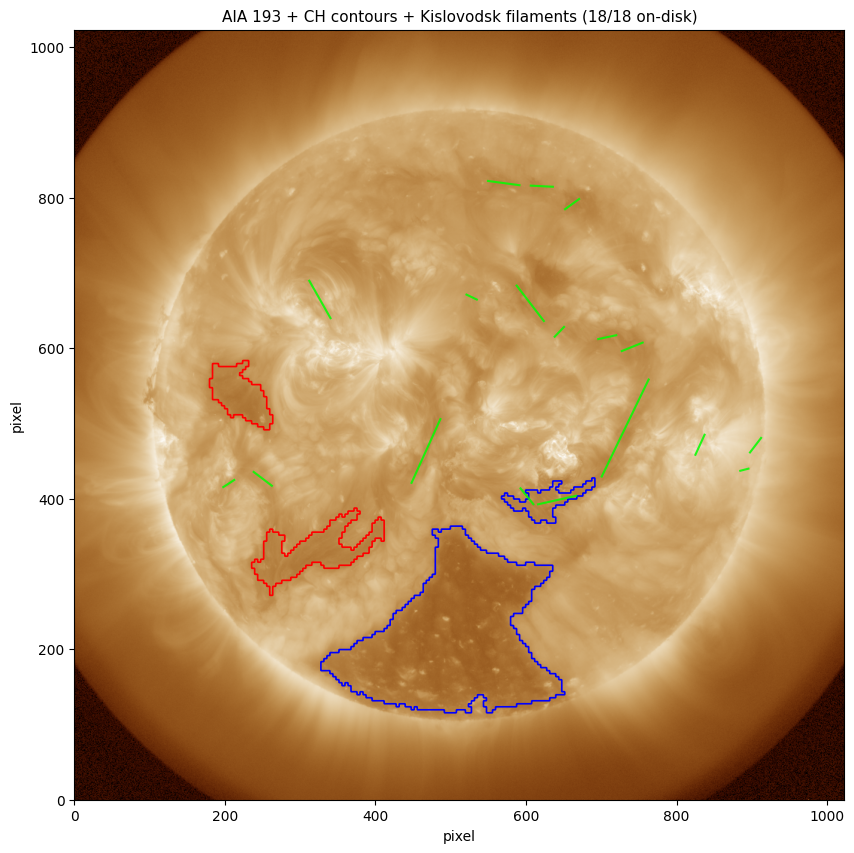

In [28]:
obs = load_observation(row)
theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])
hmi_corr, angle_mask, _ = apply_angle_correction(
    obs["hmi"],
    theta_deg,
    cos_theta,
    angle_correction=DEFAULT_ANGLE_CORRECTION,
    mask_over_60=DEFAULT_MASK_OVER_60,
)
ch = label_coronal_holes(row, model, hmi_corr, angle_mask)

# Unclipped CH set for SDO/AIA contour overlays
sdo_mask = np.ones_like(angle_mask, dtype=bool)
ch_sdo = label_coronal_holes(row, model, obs["hmi"], sdo_mask)

plot_filament_overlay(
    obs["aia_map"],
    ch["nn_labeled"],
    ch["nn_holes"],
    filaments,
    sdo_labeled=ch_sdo["nn_labeled"],
    sdo_holes=ch_sdo["nn_holes"],
)


In [29]:
# --- demo: filament–CH soft-kernel overlap ---
for sigma in [5, 10, 20, 40]:
    overlaps = compute_filament_ch_overlap(
        ch["nn_labeled"], ch["nn_holes"], obs["aia_map"], filaments, sigma=sigma
    )
    scores = "  ".join(f"CH#{o['label']}: {o['S_C']:.4f}" for o in overlaps)
    print(f"σ={sigma:>3d}px  →  {scores}")

σ=  5px  →  CH#1: 0.0000  CH#2: 0.3231  CH#3: 0.0000  CH#4: 0.0000
σ= 10px  →  CH#1: 0.0000  CH#2: 0.5675  CH#3: 0.0000  CH#4: 0.0000
σ= 20px  →  CH#1: 0.0004  CH#2: 0.8243  CH#3: 0.0003  CH#4: 0.0000
σ= 40px  →  CH#1: 0.0600  CH#2: 0.9485  CH#3: 0.0527  CH#4: 0.0114


# Huge Interactive Plot

In [30]:
def compute_megaplot_stats(
    row,
    model,
    B_thresh=DEFAULT_B_THRESH,
    smoothing_params=None,
    angle_correction=DEFAULT_ANGLE_CORRECTION,
    mask_over_60=DEFAULT_MASK_OVER_60,
    filaments_df=None,
    sigma_filament=10.0,
    hmi_smooth=DEFAULT_HMI_SMOOTH,
    mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
 ):
    """
    Compute megaplot stats and supporting data without plotting.
    """
    obs = load_observation(row)

    hmi_raw = obs["hmi"].astype(np.float32)

    # Build on-disk mask in display convention (HMI is already flipud in load_observation)
    aia_map = obs["aia_map"]
    hpc_coords = all_coordinates_from_map(aia_map)
    disk_mask = coordinate_is_on_solar_disk(hpc_coords)
    disk_mask = np.flipud(disk_mask)

    theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])

    sigma = DEFAULT_HMI_SMOOTH_SIGMA if hmi_smooth else 0.0
    hmi_stage4, hmi_corr, angle_mask, angle_cutoff, mu_map = process_hmi_ordered(
        hmi_raw,
        theta_deg,
        cos_theta,
        disk_mask,
        angle_correction=angle_correction,
        mask_over_60=mask_over_60,
        sigma=sigma,
        b_center_cutoff=B_thresh,
        mu_correct_weak_field=mu_correct_weak_field,
    )

    hmi_input = hmi_stage4
    hmi_display = hmi_input.copy()

    ch = label_coronal_holes(
        row,
        model,
        hmi_corr,
        angle_mask,
        smoothing_params=smoothing_params,
    )

    # Keep SDO overlays unclipped even when theta clipping is enabled.
    sdo_mask = np.ones_like(angle_mask, dtype=bool)
    ch_sdo = label_coronal_holes(
        row,
        model,
        hmi_corr,
        sdo_mask,
        smoothing_params=smoothing_params,
    )

    merged_labeled, merged_holes = build_merged_holes(
        ch["nn_labeled"], ch_sdo["nn_labeled"], hmi_corr
    )

    if filaments_df is None:
        filaments_df = load_kislovodsk_filaments(row.name)

    corr_label = "B_r (angle-corrected)" if angle_correction else "B_los (raw)"
    mask_label = f" | theta<={angle_cutoff:.0f} deg" if angle_cutoff is not None else ""

    hole_304_stats = None
    disk_brightness_304 = None
    if obs["has_304"]:
        disk_brightness_304 = compute_304_disk_brightness(obs["aia304"])
        merged_labels = [hole["label"] for hole in merged_holes]
        hole_304_stats = extract_304_hole_stats_by_labels(
            obs["aia304"], ch_sdo["nn_labeled"], merged_labels
        )

    filament_overlaps = compute_filament_ch_overlap(
        merged_labeled,
        merged_holes,
        obs["aia_map"],
        filaments_df,
        sigma=sigma_filament,
    )

    stats_table = build_stats_table_data(
        merged_holes,
        B_thresh=B_thresh,
        filament_overlaps=filament_overlaps,
        sigma_filament=sigma_filament,
        hole_304_stats=hole_304_stats,
    )

    return {
        "obs": obs,
        "ch": ch,
        "ch_sdo": ch_sdo,
        "merged_labeled": merged_labeled,
        "merged_holes": merged_holes,
        "hmi_display": hmi_display,
        "hmi_corrected": hmi_corr,
        "hmi_stage4": hmi_stage4,
        "angle_mask": angle_mask,
        "angle_cutoff": angle_cutoff,
        "filaments_df": filaments_df,
        "filament_overlaps": filament_overlaps,
        "hole_304_stats": hole_304_stats,
        "disk_brightness_304": disk_brightness_304,
        "stats_table": stats_table,
        "corr_label": corr_label,
        "mask_label": mask_label,
    }


In [31]:
def plot_with_polarity(
    row,
    model,
    B_thresh=DEFAULT_B_THRESH,
    smoothing_params=None,
    angle_correction=DEFAULT_ANGLE_CORRECTION,
    mask_over_60=DEFAULT_MASK_OVER_60,
    filaments_df=None,
    sigma_filament=10.0,
    hmi_smooth=DEFAULT_HMI_SMOOTH,
    mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
 ):
    """
    Full polarity analysis pipeline.

    1. Load observation (AIA 193, 304, HMI)
    2. (optional) Gaussian-smooth HMI (sigma=DEFAULT_HMI_SMOOTH_SIGMA px)
    3. Compute heliocentric angles
    4. Apply angle correction / cutoff
    5. Label coronal holes (U-Net)
    6. Plot multi-band images with contours
    7. Plot per-hole histograms (HMI)
    8. Plot 304 A brightness analysis
    9. Compute filament-CH soft-kernel overlap
    10. Display styled statistics table
    """
    obs = load_observation(row)

    hmi_raw = obs["hmi"].astype(np.float32)

    # Build on-disk mask in display convention (HMI already flipud in load_observation)
    aia_map = obs["aia_map"]
    hpc_coords = all_coordinates_from_map(aia_map)
    disk_mask = coordinate_is_on_solar_disk(hpc_coords)
    disk_mask = np.flipud(disk_mask)

    theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])

    sigma = DEFAULT_HMI_SMOOTH_SIGMA if hmi_smooth else 0.0
    hmi_stage4, hmi_corr, angle_mask, angle_cutoff, mu_map = process_hmi_ordered(
        hmi_raw,
        theta_deg,
        cos_theta,
        disk_mask,
        angle_correction=angle_correction,
        mask_over_60=mask_over_60,
        sigma=sigma,
        b_center_cutoff=B_thresh,
        mu_correct_weak_field=mu_correct_weak_field,
    )

    hmi_input = hmi_stage4

    ch = label_coronal_holes(
        row,
        model,
        hmi_corr,
        angle_mask,
        smoothing_params=smoothing_params,
    )

    # Keep SDO overlays unclipped even when theta clipping is enabled.
    sdo_mask = np.ones_like(angle_mask, dtype=bool)
    ch_sdo = label_coronal_holes(
        row,
        model,
        hmi_corr,
        sdo_mask,
        smoothing_params=smoothing_params,
    )

    merged_labeled, merged_holes = build_merged_holes(
        ch["nn_labeled"], ch_sdo["nn_labeled"], hmi_corr
    )

    if filaments_df is None:
        filaments_df = load_kislovodsk_filaments(row.name)

    corr_label = "B_r (angle-corrected)" if angle_correction else "B_los (raw)"
    mask_label = f" | theta<={angle_cutoff:.0f} deg" if angle_cutoff is not None else ""

    plot_multiband(
        obs["aia"],
        hmi_corr,
        ch["nn_labeled"],
        ch["nn_holes"],
        aia304=obs["aia304"],
        has_304=obs["has_304"],
        corr_label=corr_label,
        mask_label=mask_label,
        aia_map=obs["aia_map"],
        filaments_df=filaments_df,
        sdo_labeled=ch_sdo["nn_labeled"],
        sdo_holes=ch_sdo["nn_holes"],
        crop_mask=angle_mask if angle_cutoff is not None else None,
    )
    plot_hole_histograms(merged_holes, B_thresh=B_thresh)

    # 304 A brightness analysis
    hole_304_stats = None
    if obs["has_304"]:
        disk_brightness_304 = compute_304_disk_brightness(obs["aia304"])
        plot_304_brightness_analysis(
            obs["aia304"],
            ch_sdo["nn_labeled"],
            ch_sdo["nn_n_holes"],
            disk_brightness=disk_brightness_304,
        )
        merged_labels = [hole["label"] for hole in merged_holes]
        hole_304_stats = extract_304_hole_stats_by_labels(
            obs["aia304"], ch_sdo["nn_labeled"], merged_labels
        )

    # Filament-CH soft-kernel overlap
    filament_overlaps = compute_filament_ch_overlap(
        merged_labeled,
        merged_holes,
        obs["aia_map"],
        filaments_df,
        sigma=sigma_filament,
    )

    styler = build_stats_table(
        merged_holes,
        B_thresh=B_thresh,
        corr_label=corr_label,
        mask_label=mask_label,
        filament_overlaps=filament_overlaps,
        sigma_filament=sigma_filament,
        hole_304_stats=hole_304_stats,
        hmi_smooth=hmi_smooth,
    )
    display(styler)

    return {
        **ch,
        **obs,
        "ch_sdo": ch_sdo,
        "merged_labeled": merged_labeled,
        "merged_holes": merged_holes,
        "hmi_corrected": hmi_corr,
        "hmi_stage4": hmi_stage4,
        "angle_mask": angle_mask,
        "filament_overlaps": filament_overlaps,
    }


# Interactive Dataset Explorer

Scroll through the entire dataframe with configurable polarity analysis options.

In [32]:
# Preserve state across re-runs
try:
    last_polarity_row_idx
except NameError:
    last_polarity_row_idx = 0

try:
    last_b_thresh
except NameError:
    last_b_thresh = DEFAULT_B_THRESH

try:
    filament_cache
except NameError:
    filament_cache = {}

# Prepare dataframe with date labels
df_with_date = df.dropna(subset=["hmi_path"]).copy()
df_with_date["date"] = pd.to_datetime(
    df_with_date.index, format="%Y%m%d_%H%M"
).strftime("%Y-%m-%d %H:%M")

if last_polarity_row_idx >= len(df_with_date):
    last_polarity_row_idx = max(0, len(df_with_date) - 1)

# --- Widgets ---
full_row = widgets.Layout(width="100%")
checkbox_layout = widgets.Layout(margin="0 0 0 12px")

polarity_idx_slider = widgets.IntSlider(
    value=last_polarity_row_idx,
    min=0,
    max=max(0, len(df_with_date) - 1),
    step=1,
    description="Row:",
    continuous_update=False,
    layout=full_row,
)
b_thresh_slider = widgets.IntSlider(
    value=last_b_thresh,
    min=0,
    max=50,
    step=1,
    description="B thresh [G]:",
    continuous_update=False,
    layout=full_row,
)
angle_correction_checkbox = widgets.Checkbox(
    value=DEFAULT_ANGLE_CORRECTION,
    description="Angle correction (B_los -> B_r)",
    layout=checkbox_layout,
)
mask_over_60_checkbox = widgets.Checkbox(
    value=DEFAULT_MASK_OVER_60,
    description="Mask theta > 60 deg",
    layout=checkbox_layout,
)
hmi_smooth_checkbox = widgets.Checkbox(
    value=DEFAULT_HMI_SMOOTH,
    description=f"Smooth HMI (sigma={DEFAULT_HMI_SMOOTH_SIGMA:.1f} px)",
    layout=checkbox_layout,
)

polarity_out = widgets.Output()


def update_polarity_plot(change=None):
    global last_polarity_row_idx, last_b_thresh, filament_cache
    with polarity_out:
        clear_output(wait=True)
        if len(df_with_date) == 0:
            print("No valid data available")
            return

        row = df_with_date.iloc[polarity_idx_slider.value]
        date_str = row["date"]
        b_thresh = int(b_thresh_slider.value)

        polarity_idx_slider.description = f"{date_str}"
        polarity_idx_slider.style = {"description_width": "initial"}

        last_polarity_row_idx = polarity_idx_slider.value
        last_b_thresh = b_thresh

        print(f"\n{'=' * 100}")
        print(f"Date: {date_str:^96}|")
        print(f"Index: {row.name:^94}|")
        print(f"B_thresh: {b_thresh:^90}|")
        print(f"{'=' * 100}")
        print(f"FITS Path: {row.fits_path}")
        print(f"HMI Path:  {row.hmi_path}")
        print(f"Mask Path: {row.mask_path}")
        print(f"{'=' * 100}\n")

        filament_key = str(row.name)
        filaments_df = filament_cache.get(filament_key)
        if filaments_df is None or len(filaments_df) == 0:
            try:
                filaments_df = load_kislovodsk_filaments(filament_key)
            except Exception as exc:
                print(f"Filament catalog unavailable: {exc}")
                filaments_df = None
            filament_cache[filament_key] = filaments_df

        plot_with_polarity(
            row,
            model,
            B_thresh=b_thresh,
            angle_correction=angle_correction_checkbox.value,
            mask_over_60=mask_over_60_checkbox.value,
            filaments_df=filaments_df,
            hmi_smooth=hmi_smooth_checkbox.value,
            mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
        )


for w in [
    polarity_idx_slider,
    b_thresh_slider,
    angle_correction_checkbox,
    mask_over_60_checkbox,
    hmi_smooth_checkbox,
]:
    w.observe(update_polarity_plot, names="value")

polarity_controls = widgets.VBox(
    [
        widgets.HBox([polarity_idx_slider], layout=full_row),
        widgets.HBox([b_thresh_slider], layout=full_row),
        widgets.HBox(
            [angle_correction_checkbox, mask_over_60_checkbox, hmi_smooth_checkbox],
            layout=full_row,
        ),
        polarity_out,
    ],
    layout=full_row,
)

display(polarity_controls)
update_polarity_plot(None)

# Ad-hoc files — 2024-07-31 18:00

AIA shape: (1024, 1024), dummy mask saved to /tmp/AIA20240731_1800_0193_CH_MASK_FINAL.png


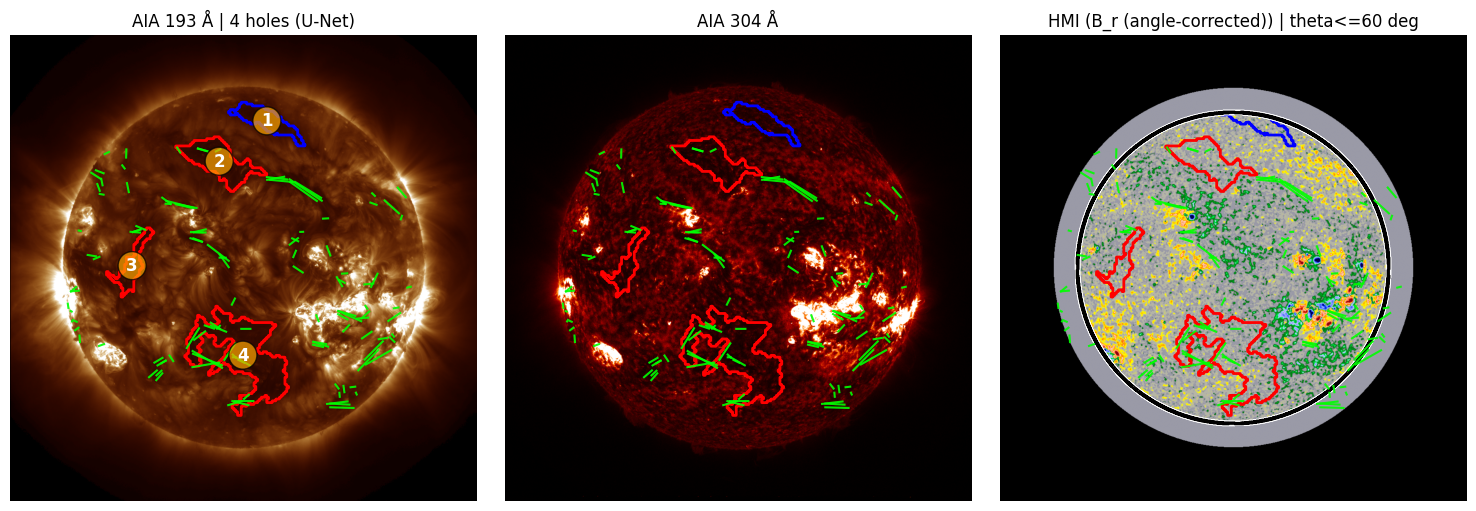

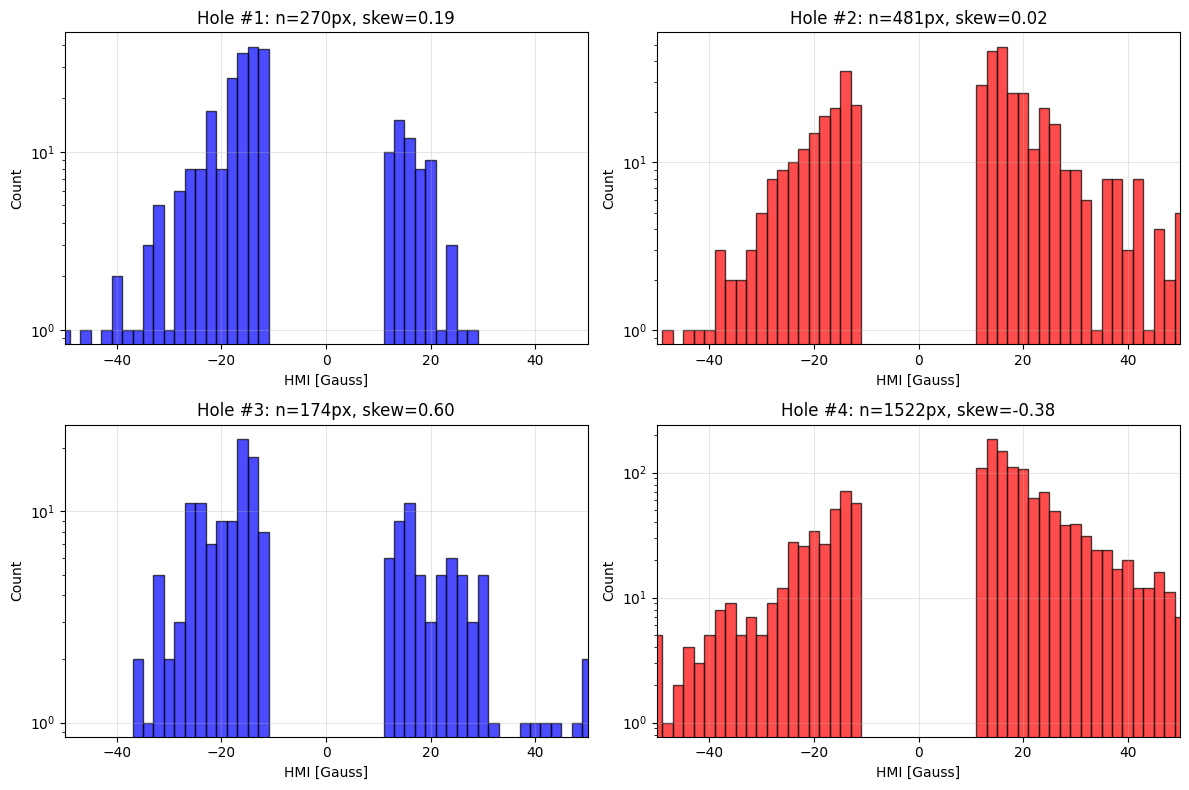

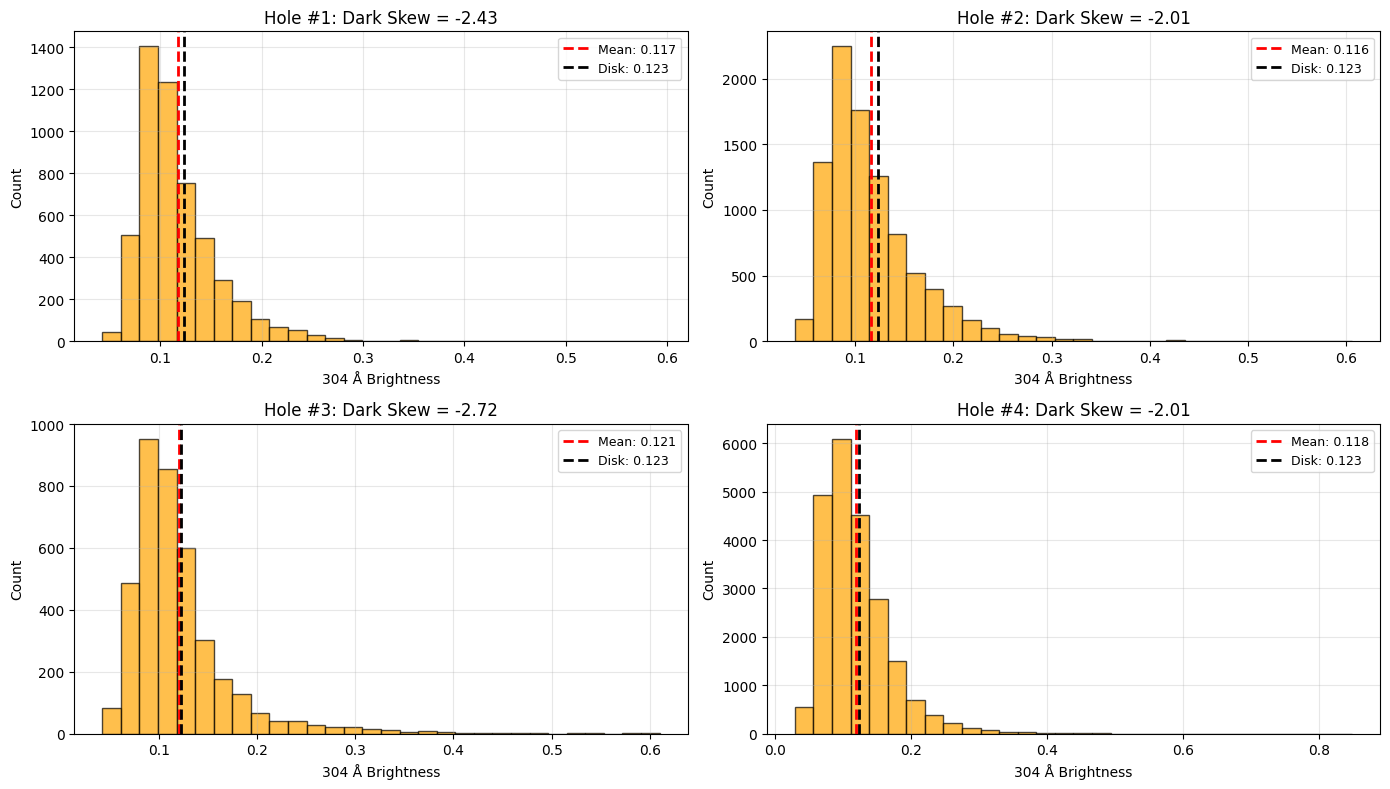

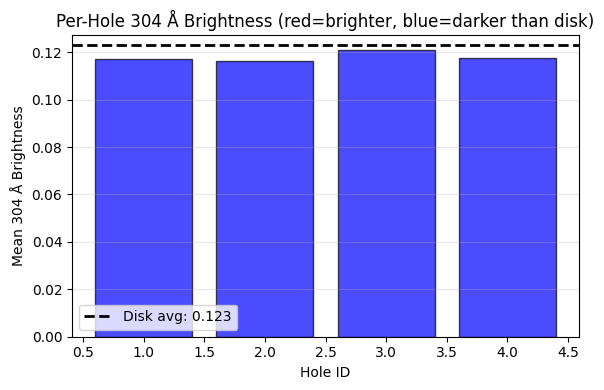

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_6983/2186605902.py:128: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(_colour_polarity, subset=["B_mean [G]", "B_mean_thr"])


,Area [px],Elong,S_C(σ10),B_mean [G],B_mean_thr,HMI skew,HMI skew_thr,|Σ|/Σ||,|Σ|/Σ||_thr,Sum+ [G],Sum- [G],Sum+_thr,Sum-_thr,304 mean,304 dark skew
CH,,,,,,,,,,,,,,,
1,"3,801",0.77,0.0000,-1.2,-11.9,-1.88,0.19,0.258,0.618,6.62e+03,-1.12e+04,9.93e+02,-4.20e+03,0.117,-2.43
2,"9,248",0.57,0.2292,0.6,8.9,2.47,0.02,0.165,0.388,2.03e+04,-1.46e+04,7.64e+03,-3.37e+03,0.116,-2.01
3,"3,872",0.71,0.0675,0.1,-3.8,0.08,0.60,0.037,0.182,7.78e+03,-7.23e+03,1.49e+03,-2.15e+03,0.121,-2.72
4,"21,984",0.40,0.3768,1.2,12.1,2.08,-0.38,0.287,0.525,6.03e+04,-3.34e+04,2.67e+04,-8.32e+03,0.118,-2.01


{'nn_labeled': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'nn_n_holes': 4,
 'nn_holes': [{'label': 1,
   'hmi_values': array([ 0.22251078, -1.6420698 , -2.0766425 , ..., -2.5320122 ,
          -0.8582434 , -0.6323815 ], dtype=float32),
   'area_px': 3801,
   'centroid': (np.float64(197.46382530912916), np.float64(575.5219679031834)),
   'mean_hmi': -1.2129364013671875,
   'std_hmi': 7.104837894439697,
   'elongation': 0.7731511042629067},
  {'label': 2,
   'hmi_values': array([-12.025624,  -8.575349,  -4.906963, ...,  14.642668,  19.32387 ,
           12.25211 ], dtype=float32),
   'area_px': 9248,
   'centroid': (np.float64(277.1401384083045), np.float64(459.01557093425606)),
   'mean_hmi': 0.6217131018638611,
   'std_hmi': 6.826730251312256,
   'elongation': 0.5692054616420101},
  {'label': 3,
   'hmi_va

In [33]:
from PIL import Image as _PILImage
from astropy.io import fits as _fits

_base = "/Users/aosh/Library/CloudStorage/GoogleDrive-anton.o.shiryaev@gmail.com/.shortcut-targets-by-id/1bJu_5-wtS4rVCXg_WC-EPPrv4ZC8JQyf/Solar Wind/Конференции/2026 Апатитский семинар/Капорцева"

_aia193_path = f"{_base}/AIA20240731_1800_0193.fits"
_hmi_path = f"{_base}/hmi.M_720s.20240731_180000_TAI.fits"
_aia304_path = f"{_base}/AIA20240731_1800_0304.fits"

# Read actual image shape so the blank mask broadcasts correctly
with _fits.open(_aia193_path) as _hdul:
    _shape = _hdul[1].data.shape if len(_hdul) > 1 else _hdul[0].data.shape

# Blank mask — IDL CH mask placeholder (not used for plotting)
_dummy_mask_path = "/tmp/AIA20240731_1800_0193_CH_MASK_FINAL.png"
_PILImage.fromarray(np.zeros(_shape, dtype=np.uint8)).save(_dummy_mask_path)
print(f"AIA shape: {_shape}, dummy mask saved to {_dummy_mask_path}")

adhoc_row = pd.Series(
    {
        "fits_path": _aia193_path,
        "hmi_path": _hmi_path,
        "aia304_path": _aia304_path,
        "mask_path": _dummy_mask_path,
        "date": "2024-07-31 18:00",
    },
    name="20240731_1800",
)

plot_with_polarity(adhoc_row, model, hmi_smooth=DEFAULT_HMI_SMOOTH)

# COSPAR ISWAT

Benchmark evaluation on the [COSPAR ISWAT community dataset](https://doi.org/10.5281/zenodo.23997993) (30 dates, 2014–2021).
AIA 193/304 and HMI FITS are 4096×4096; they are downsampled to 1024×1024 to match the training resolution before entering the pipeline.

In [ ]:
import PIL.Image

ISWAT_ROOT = Path("/Volumes/Aux Disk/COSPAR ISWAT CH dataset")
ISWAT_CACHE = Path("/tmp/iswat_1024")
ISWAT_CACHE.mkdir(exist_ok=True)

# ---------------------------------------------------------------------------
# Filename parsers — extract date key "YYYYMMDD_HHMM" from each instrument
# ---------------------------------------------------------------------------

def _parse_aia_datekey(fname):
    """aia.lev1.193A_2014-07-15T22_00_06.84Z.image_lev1.fits → 20140715_2200"""
    m = re.search(r"(\d{4})-(\d{2})-(\d{2})T(\d{2})_(\d{2})", fname)
    return f"{m.group(1)}{m.group(2)}{m.group(3)}_{m.group(4)}{m.group(5)}" if m else None


def _parse_hmi_datekey(fname):
    """hmi.m_45s.2014.07.15_22_00_00_TAI.magnetogram.fits → 20140715_2200"""
    m = re.search(r"(\d{4})\.(\d{2})\.(\d{2})_(\d{2})_(\d{2})", fname)
    return f"{m.group(1)}{m.group(2)}{m.group(3)}_{m.group(4)}{m.group(5)}" if m else None


# ---------------------------------------------------------------------------
# Resample helper — downsample 4096 → 1024 and cache as FITS
# ---------------------------------------------------------------------------

def _resample_fits(src, dst):
    """Resample a FITS file to 1024×1024 using sunpy; skip if cached."""
    if dst.exists():
        return
    m = sunpy.map.Map(str(src))
    if m.data.shape != (1024, 1024):
        m = m.resample([1024, 1024] * u.pix)
    m.save(str(dst), overwrite=True)


# ---------------------------------------------------------------------------
# Index files by date key
# ---------------------------------------------------------------------------

aia193_by_date = {}
for f in sorted(ISWAT_ROOT.glob("193/*.fits")):
    k = _parse_aia_datekey(f.name)
    if k:
        aia193_by_date[k] = f

aia304_by_date = {}
for f in sorted(ISWAT_ROOT.glob("304/*.fits")):
    k = _parse_aia_datekey(f.name)
    if k:
        aia304_by_date[k] = f

hmi_by_date = {}
for f in sorted(ISWAT_ROOT.glob("HMI/*.fits")):
    k = _parse_hmi_datekey(f.name)
    if k:
        hmi_by_date[k] = f

annot_by_date = {}
for f in sorted((ISWAT_ROOT / "Coronal Hole Labels" / "Labels").glob("*-annot.png")):
    k = _parse_aia_datekey(f.name)
    if k:
        annot_by_date[k] = f

common_dates = sorted(set(aia193_by_date) & set(hmi_by_date))
print(f"193: {len(aia193_by_date)}  304: {len(aia304_by_date)}  HMI: {len(hmi_by_date)}  annot: {len(annot_by_date)}")
print(f"Common dates (193 ∩ HMI): {len(common_dates)}")

# ---------------------------------------------------------------------------
# Resample every FITS to 1024×1024 and build the DataFrame
# ---------------------------------------------------------------------------

rows = {}
for date_key in common_dates:
    # 193
    dst193 = ISWAT_CACHE / f"193_{date_key}.fits"
    _resample_fits(aia193_by_date[date_key], dst193)

    # HMI
    dst_hmi = ISWAT_CACHE / f"HMI_{date_key}.fits"
    _resample_fits(hmi_by_date[date_key], dst_hmi)

    # 304 (optional)
    dst304 = None
    if date_key in aia304_by_date:
        dst304 = ISWAT_CACHE / f"304_{date_key}.fits"
        _resample_fits(aia304_by_date[date_key], dst304)

    # Blank dummy mask — must follow the CH_MASK_FINAL naming convention
    # so that pmap_path / base_output_stem can derive the pmap cache path.
    dummy_mask = ISWAT_CACHE / f"AIA{date_key}_0193_CH_MASK_FINAL.png"
    if not dummy_mask.exists():
        PIL.Image.fromarray(np.zeros((1024, 1024), dtype=np.uint8)).save(str(dummy_mask))

    row_data = {
        "fits_path": str(dst193),
        "hmi_path": str(dst_hmi),
        "mask_path": str(dummy_mask),
        "aia304_path": str(dst304) if dst304 else np.nan,
        "annot_path": str(annot_by_date[date_key]) if date_key in annot_by_date else np.nan,
    }
    rows[date_key] = row_data

df_iswat = pd.DataFrame.from_dict(rows, orient="index")
df_iswat.index.name = "date_key"
print(f"\nDataFrame: {len(df_iswat)} rows")
df_iswat

193: 29  304: 29  HMI: 29  annot: 29
Common dates (193 ∩ HMI): 28

DataFrame: 28 rows


,fits_path,hmi_path,mask_path,aia304_path,annot_path
date_key,,,,,
20140715_2200,/tmp/iswat_1024/193_20140715_2200.fits,/tmp/iswat_1024/HMI_20140715_2200.fits,/tmp/iswat_1024/AIA20140715_2200_0193_CH_MASK_...,/tmp/iswat_1024/304_20140715_2200.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20141002_1000,/tmp/iswat_1024/193_20141002_1000.fits,/tmp/iswat_1024/HMI_20141002_1000.fits,/tmp/iswat_1024/AIA20141002_1000_0193_CH_MASK_...,/tmp/iswat_1024/304_20141002_1000.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150104_0600,/tmp/iswat_1024/193_20150104_0600.fits,/tmp/iswat_1024/HMI_20150104_0600.fits,/tmp/iswat_1024/AIA20150104_0600_0193_CH_MASK_...,/tmp/iswat_1024/304_20150104_0600.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150121_0000,/tmp/iswat_1024/193_20150121_0000.fits,/tmp/iswat_1024/HMI_20150121_0000.fits,/tmp/iswat_1024/AIA20150121_0000_0193_CH_MASK_...,/tmp/iswat_1024/304_20150121_0000.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150210_1200,/tmp/iswat_1024/193_20150210_1200.fits,/tmp/iswat_1024/HMI_20150210_1200.fits,/tmp/iswat_1024/AIA20150210_1200_0193_CH_MASK_...,/tmp/iswat_1024/304_20150210_1200.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150331_1800,/tmp/iswat_1024/193_20150331_1800.fits,/tmp/iswat_1024/HMI_20150331_1800.fits,/tmp/iswat_1024/AIA20150331_1800_0193_CH_MASK_...,/tmp/iswat_1024/304_20150331_1800.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150606_1900,/tmp/iswat_1024/193_20150606_1900.fits,/tmp/iswat_1024/HMI_20150606_1900.fits,/tmp/iswat_1024/AIA20150606_1900_0193_CH_MASK_...,/tmp/iswat_1024/304_20150606_1900.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150811_1500,/tmp/iswat_1024/193_20150811_1500.fits,/tmp/iswat_1024/HMI_20150811_1500.fits,/tmp/iswat_1024/AIA20150811_1500_0193_CH_MASK_...,/tmp/iswat_1024/304_20150811_1500.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...
20150818_0000,/tmp/iswat_1024/193_20150818_0000.fits,/tmp/iswat_1024/HMI_20150818_0000.fits,/tmp/iswat_1024/AIA20150818_0000_0193_CH_MASK_...,/tmp/iswat_1024/304_20150818_0000.fits,/Volumes/Aux Disk/23997993/Coronal Hole Labels...


In [35]:
# --- Off-disk HMI check (raw SunPy maps, no reprojection/smoothing) ---
offdisk_rows = []

for date_key, row in df_iswat.iterrows():
    hmi_map = sunpy.map.Map(row["hmi_path"])
    hmi_data = np.asarray(hmi_map.data, dtype=np.float64)

    hpc_coords = all_coordinates_from_map(hmi_map)
    on_disk = coordinate_is_on_solar_disk(hpc_coords)
    off_disk = ~on_disk

    off_vals = hmi_data[off_disk]
    off_vals = off_vals[np.isfinite(off_vals)]

    offdisk_rows.append(
        {
            "date_key": date_key,
            "n_off_px": int(off_vals.size),
            "off_disk_mean_G": float(np.mean(off_vals)),
            "off_disk_abs_mean_G": float(np.mean(np.abs(off_vals))),
            "off_disk_median_G": float(np.median(off_vals)),
            "off_disk_p95_abs_G": float(np.percentile(np.abs(off_vals), 95)),
        }
    )

df_iswat_offdisk_hmi = pd.DataFrame(offdisk_rows).set_index("date_key").sort_index()

print("Per-date off-disk mean field (G) from raw HMI maps:")
display(df_iswat_offdisk_hmi)

print("Across-date mean(off_disk_mean_G):", float(df_iswat_offdisk_hmi["off_disk_mean_G"].mean()))
print("Across-date mean(off_disk_abs_mean_G):", float(df_iswat_offdisk_hmi["off_disk_abs_mean_G"].mean()))


Per-date off-disk mean field (G) from raw HMI maps:


,n_off_px,off_disk_mean_G,off_disk_abs_mean_G,off_disk_median_G,off_disk_p95_abs_G
date_key,,,,,
20140715_2200,67312,0.561625,69.884070,2.250000e-01,169.40000
20141002_1000,68273,-0.016225,67.937738,7.500000e-02,167.65000
20150104_0600,69467,1.378978,66.823984,6.250000e-01,164.90000
20150121_0000,69414,0.660310,72.721021,0.000000e+00,177.93375
20150210_1200,69189,0.355528,68.895268,3.250000e-01,169.70000
20150331_1800,68405,-1.032611,64.642385,-6.000000e-01,160.49500
20150606_1900,67380,-0.654789,65.950209,2.000000e-01,159.75125
20150811_1500,67415,-0.211711,70.333731,1.000000e-01,170.51500
20150818_0000,67538,2.781423,71.995577,2.850000e+00,176.37500


Across-date mean(off_disk_mean_G): -0.023854883017836653
Across-date mean(off_disk_abs_mean_G): 69.26019316697197


In [36]:
# ── Process all ISWAT dates (silent) ──
iswat_results = {}
print(f"Processing {len(df_iswat)} ISWAT dates...")

for i, (date_key, iswat_row) in enumerate(df_iswat.iterrows()):
    print(f"\r[{i+1}/{len(df_iswat)}] {date_key}", end="", flush=True)
    result = compute_megaplot_stats(
        iswat_row,
        model,
        hmi_smooth=DEFAULT_HMI_SMOOTH,
        B_thresh=DEFAULT_B_THRESH,
        mask_over_60=DEFAULT_MASK_OVER_60,
        angle_correction=DEFAULT_ANGLE_CORRECTION,
        mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
    )
    iswat_results[date_key] = result

print(f"\n✓ Processed {len(iswat_results)} dates.")

# ── Interactive viewer widget ──
iswat_dates = list(iswat_results.keys())
iswat_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(iswat_dates) - 1,
    step=1,
    description="Date:",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
)
iswat_output = widgets.Output()


def show_iswat_date(idx):
    date_key = iswat_dates[idx]
    result = iswat_results[date_key]
    iswat_row = df_iswat.loc[date_key]
    obs = result["obs"]
    ch = result["ch"]
    ch_sdo = result.get("ch_sdo", ch)
    merged_holes = result.get("merged_holes", ch["nn_holes"])

    with iswat_output:
        clear_output(wait=True)
        print(f"{'='*60}")
        print(f"[{idx+1}/{len(iswat_dates)}] {date_key}")
        print(f"{'='*60}")

        # --- megaplot (AIA 193 / 304 / HMI with CH contours) ---
        plot_multiband(
            obs["aia"],
            result["hmi_corrected"],
            ch["nn_labeled"],
            ch["nn_holes"],
            aia304=obs["aia304"],
            has_304=obs["has_304"],
            corr_label=result["corr_label"],
            mask_label=result["mask_label"],
            aia_map=obs["aia_map"],
            filaments_df=result["filaments_df"],
            sdo_labeled=ch_sdo["nn_labeled"],
            sdo_holes=ch_sdo["nn_holes"],
            crop_mask=result["angle_mask"] if result["angle_cutoff"] is not None else None,
        )

        # --- annotation comparison: ISWAT annotated image beside NN mask (north-up) ---
        if pd.notna(iswat_row.get("annot_path")):
            annot_img = plt.imread(iswat_row["annot_path"])

            fig_cmp, axes_cmp = plt.subplots(1, 2, figsize=(14, 6))

            axes_cmp[0].imshow(annot_img)
            axes_cmp[0].set_title(f"ISWAT annotation — {date_key}")
            axes_cmp[0].axis("off")

            nn_mask_display = (ch_sdo["nn_labeled"] > 0).astype(float)
            axes_cmp[1].imshow(obs["aia"], cmap="sdoaia193")
            axes_cmp[1].contour(nn_mask_display, levels=[0.5], colors="red", linewidths=0.8)
            _overlay_contours(axes_cmp[1], ch_sdo["nn_labeled"], ch_sdo["nn_holes"], show_labels=True)
            axes_cmp[1].set_title(f"NN CH mask — {date_key}")
            axes_cmp[1].axis("off")

            fig_cmp.tight_layout()
            plt.show()

        # --- HMI histograms per hole ---
        plot_hole_histograms(merged_holes, B_thresh=DEFAULT_B_THRESH)

        # --- 304 analysis ---
        if obs["has_304"]:
            plot_304_brightness_analysis(
                obs["aia304"],
                ch_sdo["nn_labeled"],
                ch_sdo["nn_n_holes"],
                disk_brightness=result["disk_brightness_304"],
            )

        # --- stats table ---
        styler = build_stats_table(
            merged_holes,
            stats_table=result["stats_table"],
            hmi_smooth=DEFAULT_HMI_SMOOTH,
            B_thresh=DEFAULT_B_THRESH,
        )
        display(styler)


iswat_slider.observe(lambda change: show_iswat_date(change["new"]), names="value")
display(widgets.VBox([iswat_slider, iswat_output]))
show_iswat_date(0)


Processing 28 ISWAT dates...
[28/28] 20190616_0600
✓ Processed 28 dates.


In [37]:
# Aggregate per-hole stats across all ISWAT dates
all_stats = []
for date_key, result in iswat_results.items():
    tbl = result["stats_table"].copy()
    tbl["date"] = date_key
    all_stats.append(tbl)

df_iswat_stats = pd.concat(all_stats, ignore_index=True)
print(f"Total CH detections across {len(iswat_results)} dates: {len(df_iswat_stats)}")
df_iswat_stats

Total CH detections across 28 dates: 74


,Area [px],Elong,S_C(σ10),B_mean [G],B_mean_thr,HMI skew,HMI skew_thr,|Σ|/Σ||,|Σ|/Σ||_thr,Sum+ [G],Sum- [G],Sum+_thr,Sum-_thr,304 mean,304 dark skew,date
0,4192,0.706636,2.074581e-07,1.773365,16.581438,3.242721,0.195682,0.406951,0.755434,12850.677734,-5416.729492,4565.923828,-636.122742,0.218437,-1.791904,20140715_2200
1,3728,0.802992,4.300639e-01,-0.981035,-10.484578,-2.029415,0.153448,0.259599,0.559830,5215.484863,-8872.783203,717.188904,-2541.505859,0.232377,-2.308454,20140715_2200
2,13333,0.154560,6.778400e-16,-2.821113,-19.640837,-3.367163,-0.463483,0.487823,0.792329,19745.845703,-57359.742188,3371.879883,-29101.375000,0.188630,-2.806288,20140715_2200
3,29888,0.466220,4.168144e-05,0.798238,9.259896,3.416031,0.789788,0.194094,0.461629,73388.140625,-49530.421875,20669.935547,-7613.481445,0.175154,-1.894069,20141002_1000
4,5312,0.713137,4.354952e-01,-0.150733,-0.238358,-0.721653,-0.327213,0.041946,0.011789,9144.046875,-9944.740234,1968.095093,-2015.051514,0.189824,-2.290768,20141002_1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1027,0.544066,0.000000e+00,-1.711854,-13.891887,-1.254991,0.854869,0.333661,0.767813,1755.481201,-3513.555176,176.438171,-1343.356689,0.265118,-1.970714,20180623_1300
70,3950,0.702129,0.000000e+00,-1.308586,-15.095008,-2.483425,-0.095573,0.248702,0.724359,7807.330078,-12976.243164,927.676331,-5803.364258,0.322717,-1.868234,20190504_1100
71,276,0.723208,7.606247e-34,4.340117,20.397860,2.223213,2.157864,0.729385,1.000000,1420.088135,-222.215759,611.935791,0.000000,0.300169,-2.031823,20190616_0600
72,1308,0.709067,0.000000e+00,-2.531226,-16.178762,-1.833485,0.279765,0.418358,0.784537,2301.525635,-5612.369141,315.474304,-2612.858643,0.360006,-1.695923,20190616_0600


In [38]:
df_iswat_stats.loc[df_iswat_stats["S_C(σ10)"] > 0.1]

,Area [px],Elong,S_C(σ10),B_mean [G],B_mean_thr,HMI skew,HMI skew_thr,|Σ|/Σ||,|Σ|/Σ||_thr,Sum+ [G],Sum- [G],Sum+_thr,Sum-_thr,304 mean,304 dark skew,date
1,3728,0.802992,0.430064,-0.981035,-10.484578,-2.029415,0.153448,0.259599,0.559830,5215.484863,-8872.783203,717.188904,-2541.505859,0.232377,-2.308454,20140715_2200
4,5312,0.713137,0.435495,-0.150733,-0.238358,-0.721653,-0.327213,0.041946,0.011789,9144.046875,-9944.740234,1968.095093,-2015.051514,0.189824,-2.290768,20141002_1000
5,3056,0.619054,0.495634,0.334617,6.568020,1.422899,-0.085783,0.091373,0.345439,6106.981445,-5084.393555,1368.613647,-665.835449,0.167082,-1.574410,20141002_1000
12,6704,0.769507,0.244421,-1.022678,-10.950810,-2.059163,0.356609,0.267673,0.479253,9378.728516,-16234.761719,2159.659668,-6134.803711,0.171765,-2.867705,20150210_1200
20,19876,0.570541,0.179038,0.197182,3.131212,0.436637,-0.178274,0.052526,0.149003,39266.589844,-35347.390625,10877.611328,-8056.389648,0.173305,-2.891155,20150606_1900
24,2560,0.790527,0.271415,-0.255574,-5.128600,-0.815363,0.447458,0.097674,0.304566,3022.119629,-3676.389648,339.603241,-637.062073,0.220087,-2.933588,20150811_1500
26,3408,0.564107,0.554039,-0.385715,-1.267081,-2.369020,-0.704170,0.133894,0.060322,4251.542969,-5566.059570,986.910217,-1113.618286,0.214576,-3.015006,20150811_1500
31,12048,0.678030,0.185247,0.253823,2.749760,-0.035138,-0.403672,0.074876,0.149827,21949.988281,-18891.925781,3524.136230,-2605.716553,0.176356,-1.673568,20150923_0900
33,6176,0.014651,0.164187,0.339649,6.273162,2.569289,0.297495,0.103260,0.315213,11206.078125,-9108.403320,3677.518799,-1914.760254,0.221208,-1.525052,20150923_0900


In [43]:
hmi_map = sunpy.map.Map('/Volumes/Aux Disk/23997993/HMI/hmi.m_45s.2014.07.15_22_00_00_TAI.magnetogram.fits')

Observatory,SDO
Instrument,HMI FRONT2
Detector,HMI
Measurement,magnetogram
Wavelength,6173.0 Angstrom
Observation Date,2014-07-15 21:59:10
Exposure Time,Unknown
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.504312 0.504312] arcsec / pix
Reference Pixel,[2038.228638 2050.05127 ] pix

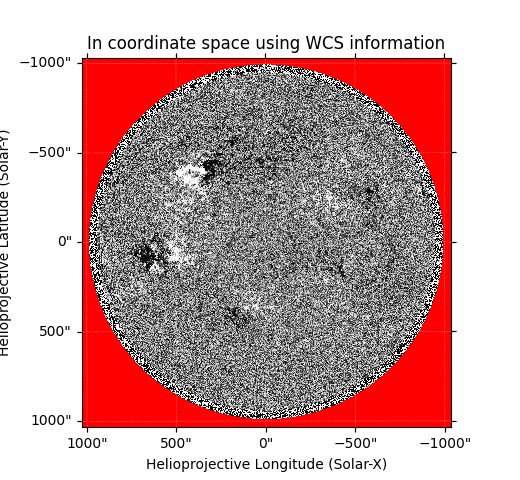
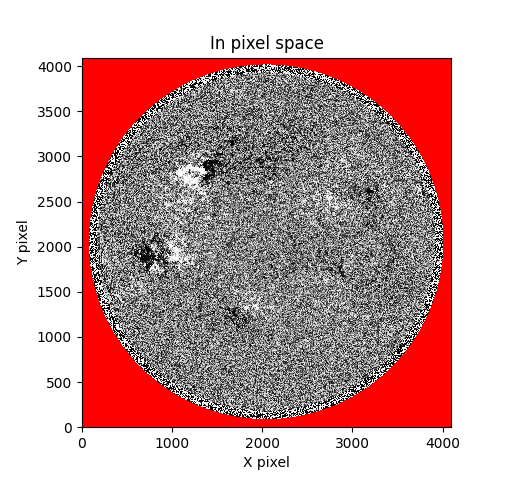
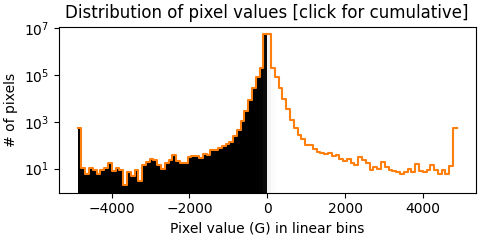
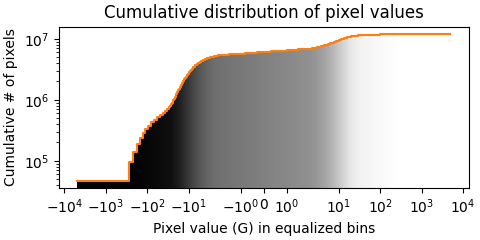

In [44]:
hmi_map

In [ ]:
import time

SC_HIGH_THRESHOLD = 0.10
SC_SIGMA_FILAMENT = 10.0
SC_COL = f"S_C(σ{SC_SIGMA_FILAMENT:.0f})"

# Full project dataset with HMI, excluding ISWAT rows if present
df_main = df.dropna(subset=["hmi_path"]).copy()
if "df_iswat" in globals():
    df_main = df_main.loc[~df_main.index.isin(df_iswat.index)]
df_main = df_main.sort_index()

n_total = len(df_main)
print(f"Processing main dataset rows (excluding ISWAT): {n_total}")

rows = []
t0 = time.perf_counter()

for i, (date_key, row) in enumerate(df_main.iterrows(), start=1):
    result = compute_megaplot_stats(
        row,
        model,
        B_thresh=DEFAULT_B_THRESH,
        angle_correction=DEFAULT_ANGLE_CORRECTION,
        mask_over_60=DEFAULT_MASK_OVER_60,
        hmi_smooth=DEFAULT_HMI_SMOOTH,
        mu_correct_weak_field=DEFAULT_MU_CORRECT_WEAK_FIELD,
        sigma_filament=SC_SIGMA_FILAMENT,
    )

    tbl = result["stats_table"]
    n_regions = int(len(tbl))
    n_high_sc = int((tbl[SC_COL] >= SC_HIGH_THRESHOLD).sum()) if n_regions > 0 else 0

    rows.append(
        {
            "date_key": date_key,
            "n_regions": n_regions,
            "n_high_sc": n_high_sc,
            "frac_high_sc": (n_high_sc / n_regions) if n_regions > 0 else np.nan,
        }
    )

    elapsed = time.perf_counter() - t0
    rate = i / elapsed if elapsed > 0 else 0.0
    eta = (n_total - i) / rate if rate > 0 else float("inf")

    bar_width = 28
    filled = int(bar_width * i / n_total) if n_total > 0 else bar_width
    bar = "#" * filled + "-" * (bar_width - filled)

    print(
        f"\r[{bar}] {i}/{n_total} elapsed={elapsed/60:.1f}m eta={eta/60:.1f}m",
        end="",
        flush=True,
    )

print()
elapsed_total = time.perf_counter() - t0

df_main_high_sc = pd.DataFrame(rows).set_index("date_key").sort_index()

total_regions = int(df_main_high_sc["n_regions"].sum())
total_high_sc = int(df_main_high_sc["n_high_sc"].sum())
overall_frac_high_sc = (total_high_sc / total_regions) if total_regions > 0 else np.nan

summary = pd.DataFrame(
    [
        {
            "sc_threshold": SC_HIGH_THRESHOLD,
            "sigma_filament": SC_SIGMA_FILAMENT,
            "n_dates": int(len(df_main_high_sc)),
            "total_regions": total_regions,
            "total_high_sc": total_high_sc,
            "overall_frac_high_sc": overall_frac_high_sc,
            "elapsed_min": elapsed_total / 60.0,
        }
    ]
)

out_dir = Path(paths["artifact_root"])
out_dir.mkdir(parents=True, exist_ok=True)
counts_path = out_dir / f"main_high_sc_counts_thr{SC_HIGH_THRESHOLD:.2f}_sigma{int(SC_SIGMA_FILAMENT)}.csv"
summary_path = out_dir / f"main_high_sc_summary_thr{SC_HIGH_THRESHOLD:.2f}_sigma{int(SC_SIGMA_FILAMENT)}.csv"

df_main_high_sc.to_csv(counts_path)
summary.to_csv(summary_path, index=False)

print(f"Saved per-date counts: {counts_path}")
print(f"Saved summary: {summary_path}")
display(summary)
display(df_main_high_sc.head())

